### 1. Importing the processed data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os

# If running from Notebooks folder:
file_path = os.path.join('..', 'Data', 'output', 'processed_data.csv')

# Alternative: If running from main project folder:
# file_path = os.path.join('Data', 'output', 'processed_data.csv')

# Read the CSV file
try:
    processed_data = pd.read_csv(file_path)
    print(f"✅ Successfully loaded: {file_path}")
    print(f"📊 Dataset shape: {processed_data.shape}")
    print(f"💾 Memory usage: {processed_data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
except FileNotFoundError:
    print(f"❌ File not found: {file_path}")
    print("Please check the file path and make sure the file exists")
except Exception as e:
    print(f"❌ Error reading file: {e}")

✅ Successfully loaded: ..\Data\output\processed_data.csv
📊 Dataset shape: (27725, 25)
💾 Memory usage: 18.5 MB


In [2]:
processed_data.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,id_assessment,date_first_assessment,date_submitted,is_banked,score,...,gender,region,highest_education,imd_band,age_band,studied_credits,disability,final_result,final_result_code,courses_per_term
0,AAA,2013J,11391,-159.0,NaN,1752,19,18.0,0.0,78.0,...,M,East Anglian Region,HE Qualification,90-100%,55<=,240,N,Pass,2,1
1,AAA,2013J,28400,-53.0,NaN,1752,19,22.0,0.0,70.0,...,F,Scotland,HE Qualification,20-30%,35-55,60,N,Pass,2,1
2,AAA,2013J,31604,-52.0,NaN,1752,19,17.0,0.0,72.0,...,F,South East Region,A Level or Equivalent,50-60%,35-55,60,N,Pass,2,1
3,AAA,2013J,32885,-176.0,NaN,1752,19,26.0,0.0,69.0,...,F,West Midlands Region,Lower Than A Level,50-60%,0-35,60,N,Pass,2,1
4,AAA,2013J,38053,-110.0,NaN,1752,19,19.0,0.0,79.0,...,M,Wales,A Level or Equivalent,80-90%,35-55,60,N,Pass,2,1


### 2. Exploration of the data by cohorts

In [3]:
# Explore cohorts (course + presentation combinations)
print("📊 COHORT ANALYSIS:")
print("=" * 50)

# Create cohort identifier
processed_data['cohort'] = processed_data['code_module'] + '_' + processed_data['code_presentation']

# Show cohort distribution
cohort_counts = processed_data['cohort'].value_counts().sort_values(ascending=False)
print(f"Total cohorts: {len(cohort_counts)}")
print(f"Total students: {len(processed_data):,}")
print(f"\nCohort sizes top 10:")
print(cohort_counts.head(10))  # Show top 10 largest cohorts

# Show outcome distribution by cohort (sample)
print(f"\n📈 Sample of outcomes by cohort:")
sample_cohorts = cohort_counts.head(5).index
for cohort in sample_cohorts:
    cohort_data = processed_data[processed_data['cohort'] == cohort]
    outcomes = cohort_data['final_result'].value_counts()
    print(f"{cohort}: {dict(outcomes)}")

📊 COHORT ANALYSIS:
Total cohorts: 22
Total students: 27,725

Cohort sizes top 10:
cohort
FFF_2013J    1995
CCC_2014J    1993
FFF_2014J    1869
BBB_2013J    1846
BBB_2014J    1807
DDD_2013J    1653
BBB_2013B    1598
FFF_2013B    1515
CCC_2014B    1479
DDD_2014J    1473
Name: count, dtype: int64

📈 Sample of outcomes by cohort:
FFF_2013J: {'Pass': 908, 'Fail': 510, 'Withdrawn': 390, 'Distinction': 187}
CCC_2014J: {'Pass': 709, 'Withdrawn': 572, 'Fail': 406, 'Distinction': 306}
FFF_2014J: {'Pass': 859, 'Fail': 393, 'Withdrawn': 359, 'Distinction': 258}
BBB_2013J: {'Pass': 896, 'Fail': 519, 'Withdrawn': 255, 'Distinction': 176}
BBB_2014J: {'Pass': 972, 'Fail': 391, 'Withdrawn': 264, 'Distinction': 180}


### 3. Stratification Analysis
- By cohort
- By cohort and outcome
- By Cohort and Outcome and Courses Per Term Stratification

In [4]:
# Strategy 1 - Simple stratification by cohort
print("🎯 STRATEGY 1: Simple Cohort Stratification")
print("=" * 50)

data_for_split = processed_data.copy()

# Stratified split by cohort
train_data, test_data = train_test_split(
    data_for_split,
    test_size=0.2,  # 80% train, 20% test
    stratify=data_for_split['cohort'],
    random_state=123
)

print(f"\n📊 Split Results:")
print(f"Training set: {len(train_data):,} students ({len(train_data)/len(data_for_split)*100:.1f}%)")
print(f"Test set: {len(test_data):,} students ({len(test_data)/len(data_for_split)*100:.1f}%)")

# Verify cohort representation
print(f"\nCohorts in training: {train_data['cohort'].nunique()}")
print(f"Cohorts in test: {test_data['cohort'].nunique()}")

🎯 STRATEGY 1: Simple Cohort Stratification

📊 Split Results:
Training set: 22,180 students (80.0%)
Test set: 5,545 students (20.0%)

Cohorts in training: 22
Cohorts in test: 22


In [5]:
# Strategy 2 - Stratify by cohort AND outcome
print("🎯 STRATEGY 2: Cohort + Outcome Stratification")
print("=" * 50)

# Create the combined stratification variable with:
# 1. Cohorts (course_module + course_presentation combinations)
# 2. Student outcomes (final_result_code: Withdrawn, Fail, Pass)

# Create combined stratification variable: cohort + outcome
data_for_split['cohort_outcome'] = (data_for_split['cohort'] + '_' + 
                                   data_for_split['final_result_code'].astype(str))

# Use cohort + outcome stratification
train_data_v2, test_data_v2 = train_test_split(
    data_for_split,
    test_size=0.2,
    stratify=data_for_split['cohort_outcome'],
    random_state=123
)

print(f"\n📊 Strategy 2 Split Results:")
print(f"Training set: {len(train_data_v2):,} students ({len(train_data_v2)/len(data_for_split)*100:.1f}%)")
print(f"Test set: {len(test_data_v2):,} students ({len(test_data_v2)/len(data_for_split)*100:.1f}%)")

# Verify cohort representation
print(f"\nCohorts in training: {train_data_v2['cohort'].nunique()}")
print(f"Cohorts in test: {test_data_v2['cohort'].nunique()}")

🎯 STRATEGY 2: Cohort + Outcome Stratification

📊 Strategy 2 Split Results:
Training set: 22,180 students (80.0%)
Test set: 5,545 students (20.0%)

Cohorts in training: 22
Cohorts in test: 22


In [6]:
# Strategy 3 - Stratify by cohort AND outcome AND courses_per_term
print("🎯 STRATEGY 3: Cohort + Outcome + Courses Per Term Stratification")
print("=" * 70)

# Create the combined stratification variable with:
# 1. Cohorts (course_module + course_presentation combinations)
# 2. Student outcomes (final_result_code: Withdrawn, Fail, Pass)
# 3. Course load (courses_per_term: number of courses taken per term)

# Create combined stratification variable: cohort + outcome + courses_per_term
data_for_split['cohort_outcome_courseload'] = (data_for_split['cohort'] + '_' + 
                                               data_for_split['final_result_code'].astype(str) + '_' +
                                               data_for_split['courses_per_term'].astype(str))

# Use cohort + outcome + courses_per_term stratification
try:
    train_data_v3, test_data_v3 = train_test_split(
        data_for_split,
        test_size=0.2,
        stratify=data_for_split['cohort_outcome_courseload'],
        random_state=123
    )    
except ValueError as e:
    print(f"\n❌ Strategy 3 Failed:")
    print(f"Triple stratification (Cohort + Outcome + Courses Per Term) cannot be applied.")
    print(f"Reason: Some combinations have too few students (need at least 2 per group).")
    print(f"\n💡 Recommendation: Use Strategy 2 (Cohort + Outcome) instead.")
    
    # Show why it failed
    groups_count = data_for_split['cohort_outcome_courseload'].value_counts()
    small_groups = groups_count[groups_count == 1]
    print(f"\nDetails: {len(small_groups)} groups have only 1 student each.")

🎯 STRATEGY 3: Cohort + Outcome + Courses Per Term Stratification

❌ Strategy 3 Failed:
Triple stratification (Cohort + Outcome + Courses Per Term) cannot be applied.
Reason: Some combinations have too few students (need at least 2 per group).

💡 Recommendation: Use Strategy 2 (Cohort + Outcome) instead.

Details: 3 groups have only 1 student each.


In [7]:
# Compare strategies and validate the splits
print("📊 COMPARING STRATEGIES:")
print("=" * 50)

# Compare outcome distributions
strategies = {
    'Original': data_for_split,
    'Strategy 1': test_data,
    'Strategy 2': test_data_v2
}

print("Final result distribution comparison:")
for name, data in strategies.items():
    dist = data['final_result_code'].value_counts(normalize=True).sort_index()
    print(f"{name:12}: {dict(dist.round(3))}")

# Check cohort representation in test sets
print(f"\n🔍 Cohort representation in test sets:")
original_cohort_dist = data_for_split['cohort'].value_counts(normalize=True)

for strategy_name, test_set in [('Strategy 1', test_data), 
                               ('Strategy 2', test_data_v2)]:
    test_cohort_dist = test_set['cohort'].value_counts(normalize=True)
    
    # Calculate how well test set represents original distribution
    shared_cohorts = set(original_cohort_dist.index) & set(test_cohort_dist.index)
    correlation = original_cohort_dist[list(shared_cohorts)].corr(test_cohort_dist[list(shared_cohorts)])
    
    print(f"{strategy_name}: {correlation:.3f} correlation with original")

print(f"\n✅ Both strategies have almost the same cohort representation and the same correlation")

📊 COMPARING STRATEGIES:
Final result distribution comparison:
Original    : {0: 0.191, 1: 0.254, 2: 0.555}
Strategy 1  : {0: 0.193, 1: 0.25, 2: 0.557}
Strategy 2  : {0: 0.191, 1: 0.254, 2: 0.555}

🔍 Cohort representation in test sets:
Strategy 1: 1.000 correlation with original
Strategy 2: 1.000 correlation with original

✅ Both strategies have almost the same cohort representation and the same correlation


### 4. Selection of the best stratification strategy and its features
Strategy 2 (Cohort + Outcome) will be selected due to its better distribution compared to the entire sample. Also it will selected the relevant features for the Machine Learning (ML) models.

In [8]:
# Import Libraries and Setup for data manipulation, modeling, and evaluation

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           precision_recall_fscore_support, recall_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Stratification Selection

# Feature Selection and Data Preparation
# Define feature columns
feature_columns = [
    # Socio-economic variables
    'region', 'highest_education', 'imd_band', 'age_band', 'disability',
    # Other variables
    #'excellent_Score' (0 or 1), 'active_in_VLE' (0 or 1),
    'excellent_Score', 'active_in_VLE',
    # Extra variable
    'student_engagementt', 'courses_per_term'
]

# Select features and target
X_train = train_data_v2[feature_columns].copy()
y_train = train_data_v2['final_result_code'].copy()

X_test = test_data_v2[feature_columns].copy()
y_test = test_data_v2['final_result_code'].copy()


print("🔧 Selected Features, Training Data:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

print(f"\n📊 Feature matrix shape: {X_train.shape}")
print(f"🎯 Target vector shape: {y_train.shape}")

# Check for missing values
print(f"\n🔍 Missing values per feature:")
missing_counts = X_train.isnull().sum()
for col in missing_counts.index:
    if missing_counts[col] > 0:
        print(f"   {col}: {missing_counts[col]} ({missing_counts[col]/len(X_train)*100:.1f}%)")
    
if missing_counts.sum() == 0:
    print("   ✅ No missing values found!")

🔧 Selected Features, Training Data:
 1. region
 2. highest_education
 3. imd_band
 4. age_band
 5. disability
 6. excellent_Score
 7. active_in_VLE
 8. student_engagementt
 9. courses_per_term

📊 Feature matrix shape: (22180, 9)
🎯 Target vector shape: (22180,)

🔍 Missing values per feature:
   imd_band: 831 (3.7%)


### 5. Enconding the training and test data
- Improved Categorical Variable Encoding Strategy
- Tailored encoding for different variable types

In [11]:
# Setup path and imports
import sys
import os

# Add the parent directory to Python path to access Python_files folder
parent_dir = os.path.dirname(os.getcwd())  # Go up one level from Notebooks to parent
python_files_path = os.path.join(parent_dir, 'Python_files')
sys.path.append(python_files_path)

# Import encoding functions from encoding_utils
from encoding_utils import encode_categorical_variables, save_encoded_data, print_encoding_summary

# Apply the encoding function
X_train_encoded, X_test_encoded, encoders_dict = encode_categorical_variables(X_train, X_test)

🔧 APPLYING TAILORED ENCODING STRATEGIES
🌍 Processing 'region' (Nominal - One-Hot Encoding)
   → Created 12 binary features
   → Original categories: ['East Anglian Region', 'East Midlands Region', 'Ireland', 'London Region', 'North Region', 'North Western Region', 'Scotland', 'South East Region', 'South Region', 'South West Region', 'Wales', 'West Midlands Region', 'Yorkshire Region']

🎓 Processing 'highest_education' (Ordinal)
   → Found education levels: ['A Level or Equivalent', 'HE Qualification', 'Lower Than A Level', 'No Formal quals', 'Post Graduate Qualification']
   → Encoded as: {'No Formal quals': 0, 'Lower Than A Level': 1, 'A Level or Equivalent': 2, 'HE Qualification': 3, 'Post Graduate Qualification': 4}

📊 Processing 'imd_band' (Ordinal with Missing Values)
   → Found 831 missing values in training data
   → Found IMD bands: ['0-10%', '10-20', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
   → Filled 831 missing values with 'Unknown' c

In [12]:
# Print summary
print_encoding_summary()

# Check the results
print("\n🔍 RESULTS:")
print(f"{'Training data shape':22}: {X_train_encoded.shape}")
print(f"{'Test data shape':22}: {X_test_encoded.shape}")

cols = list(X_train_encoded.columns)
print("\nTraining data columns:")
for col in cols:
    print(f" • {col}")



📋 ENCODING SUMMARY:
   region                : OneHotEncoder
   highest_education     : OrdinalEncoder
   imd_band              : OrdinalEncoder
   age_band              : OrdinalEncoder
   disability            : Binary

🔍 RESULTS:
Training data shape   : (22180, 20)
Test data shape       : (5545, 20)

Training data columns:
 • excellent_Score
 • active_in_VLE
 • student_engagementt
 • courses_per_term
 • region_East Midlands Region
 • region_Ireland
 • region_London Region
 • region_North Region
 • region_North Western Region
 • region_Scotland
 • region_South East Region
 • region_South Region
 • region_South West Region
 • region_Wales
 • region_West Midlands Region
 • region_Yorkshire Region
 • highest_education_ord
 • imd_band_ord
 • age_band_ord
 • disability_binary


In [ ]:
X_train_encoded.head()

,excellent_Score,active_in_VLE,student_engagementt,courses_per_term,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,highest_education_ord,imd_band_ord,age_band_ord,disability_binary
22491,1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1
8668,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0
19249,1,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-1.0,0.0,0
2090,0,1,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0
12349,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,9.0,0.0,0


In [14]:
# After encoding your data:
save_encoded_data(
    X_train_encoded=X_train_encoded,
    X_test_encoded=X_test_encoded,
    y_train=y_train,
    y_test=y_test
)

✅ Training data saved to: ..\Data\output\X_train_encoded.csv
   Shape: (22180, 20)
✅ Training labels saved to: ..\Data\output\y_train.csv
   Shape: (22180,)
✅ Test data saved to: ..\Data\output\X_test_encoded.csv
   Shape: (5545, 20)
✅ Test labels saved to: ..\Data\output\y_test.csv
   Shape: (5545,)


### 5. Random Forest (RF) Model

#### 5.1. Enconding Categorical variables for RF model

#### 5.2. Evaluating hyperparameters for RF model

### 6. Logistic Regression Model

In [ ]:
# ================================================================
# ADDITIONAL CELLS FOR GAUSSIAN NAIVE BAYES
# ================================================================

# Import GaussianNB (other libraries already imported)

from sklearn.naive_bayes import GaussianNB

In [ ]:
# Configure and Train Gaussian Naive Bayes
# Set up and train Gaussian Naive Bayes model

print("🧠 Configuring Gaussian Naive Bayes...")

# Configure Gaussian Naive Bayes
nb_model = GaussianNB(
    var_smoothing=1e-9,  # Smoothing parameter (default is good)
    priors=None          # Learn class priors from data (handles imbalance)
)

print("🔧 Gaussian Naive Bayes Parameters:")
print(f"   Variance Smoothing: {nb_model.var_smoothing}")
print(f"   Class Priors: {nb_model.priors} (learned from data)")

# Train the model (use scaled features for consistency)
print("\n🎯 Training Gaussian Naive Bayes...")
nb_model.fit(X_train_scaled, y_train_lr)
print("✅ Gaussian Naive Bayes training completed!")

# Show learned class priors
print(f"📊 Learned class priors:")
for i, class_name in enumerate(class_names):
    prior = nb_model.class_prior_[i]
    print(f"   {class_name}: {prior:.3f}")

🧠 Configuring Gaussian Naive Bayes...
🔧 Gaussian Naive Bayes Parameters:
   Variance Smoothing: 1e-09
   Class Priors: None (learned from data)

🎯 Training Gaussian Naive Bayes...
✅ Gaussian Naive Bayes training completed!
📊 Learned class priors:
   Withdrawn: 0.189
   Fail: 0.254
   Pass: 0.557


In [ ]:
# Gaussian Naive Bayes Predictions and Evaluation
# Make predictions and calculate performance metrics

print("🔮 Making Gaussian Naive Bayes predictions on test set...")

# Make predictions on test set
y_pred_nb = nb_model.predict(X_test_scaled)
y_pred_proba_nb = nb_model.predict_proba(X_test_scaled)

# Calculate basic metrics
accuracy_nb = accuracy_score(y_test_lr, y_pred_nb)
precision_nb, recall_nb, f1_nb, support_nb = precision_recall_fscore_support(y_test_lr, y_pred_nb, average='weighted')

print(f"📊 Gaussian Naive Bayes Performance on Test Set:")
print(f"   Accuracy: {accuracy_nb:.3f}")
print(f"   Weighted Precision: {precision_nb:.3f}")
print(f"   Weighted Recall: {recall_nb:.3f}")
print(f"   Weighted F1-Score: {f1_nb:.3f}")

# Class-wise performance
print(f"\n📈 Gaussian Naive Bayes Classification Report:")
print(classification_report(y_test_lr, y_pred_nb, target_names=class_names))

# Show prediction probabilities statistics
print(f"\n🎲 Prediction Probability Statistics:")
for i, class_name in enumerate(class_names):
    class_probs = y_pred_proba_nb[:, i]
    print(f"   {class_name:10s}: Mean={class_probs.mean():.3f}, Std={class_probs.std():.3f}")


🔮 Making Gaussian Naive Bayes predictions on test set...
📊 Gaussian Naive Bayes Performance on Test Set:
   Accuracy: 0.570
   Weighted Precision: 0.538
   Weighted Recall: 0.570
   Weighted F1-Score: 0.545

📈 Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

   Withdrawn       0.32      0.15      0.20      1096
        Fail       0.40      0.45      0.42      1410
        Pass       0.68      0.78      0.73      3039

    accuracy                           0.57      5545
   macro avg       0.47      0.46      0.45      5545
weighted avg       0.54      0.57      0.55      5545


🎲 Prediction Probability Statistics:
   Withdrawn : Mean=0.188, Std=0.182
   Fail      : Mean=0.257, Std=0.220
   Pass      : Mean=0.555, Std=0.376


📊 Creating Gaussian Naive Bayes Confusion Matrix...


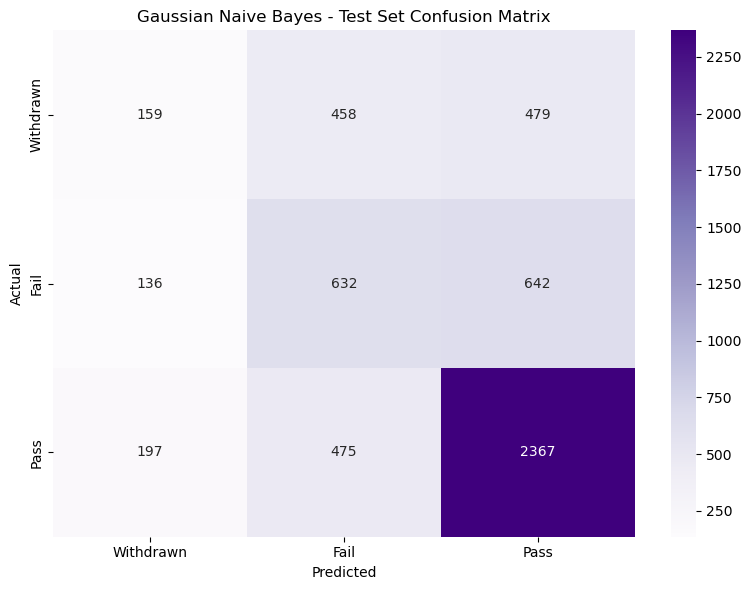


🔍 Gaussian Naive Bayes Confusion Matrix Analysis:

Withdrawn (Actual Class 0):
   Predicted as Withdrawn: 159 (14.5%)
   Predicted as Fail: 458 (41.8%)
   Predicted as Pass: 479 (43.7%)

Fail (Actual Class 1):
   Predicted as Withdrawn: 136 (9.6%)
   Predicted as Fail: 632 (44.8%)
   Predicted as Pass: 642 (45.5%)

Pass (Actual Class 2):
   Predicted as Withdrawn: 197 (6.5%)
   Predicted as Fail: 475 (15.6%)
   Predicted as Pass: 2367 (77.9%)


In [ ]:
# Gaussian Naive Bayes Confusion Matrix
# Create confusion matrix visualization

print("📊 Creating Gaussian Naive Bayes Confusion Matrix...")

# Calculate confusion matrix
cm_nb = confusion_matrix(y_test_lr, y_pred_nb)

# Create visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Purples', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Gaussian Naive Bayes - Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Print confusion matrix with percentages
print("\n🔍 Gaussian Naive Bayes Confusion Matrix Analysis:")
cm_percent_nb = cm_nb.astype('float') / cm_nb.sum(axis=1)[:, np.newaxis] * 100

for i, class_name in enumerate(class_names):
    print(f"\n{class_name} (Actual Class {i}):")
    for j, pred_class in enumerate(class_names):
        count = cm_nb[i, j]
        percent = cm_percent_nb[i, j]
        print(f"   Predicted as {pred_class}: {count} ({percent:.1f}%)")

📊 Analyzing Class-Conditional Feature Distributions...
📈 Feature Means by Class:
           region  highest_education  imd_band  age_band  disability  score  \
Withdrawn   0.001              0.096    -0.095    -0.047       0.134 -0.519   
Fail        0.018              0.138    -0.187    -0.103       0.027 -0.383   
Pass       -0.008             -0.095     0.118     0.063      -0.058  0.352   

           total_click_vle  student_engagementt  
Withdrawn           -0.183               -0.438  
Fail                -0.301               -0.416  
Pass                 0.200                0.339  

📊 Feature Variances by Class:
           region  highest_education  imd_band  age_band  disability  score  \
Withdrawn   0.991              1.008     0.986     0.955       1.358  1.311   
Fail        1.005              0.982     0.947     0.877       1.075  1.167   
Pass        1.001              0.985     0.996     1.062       0.834  0.536   

           total_click_vle  student_engagementt  
With

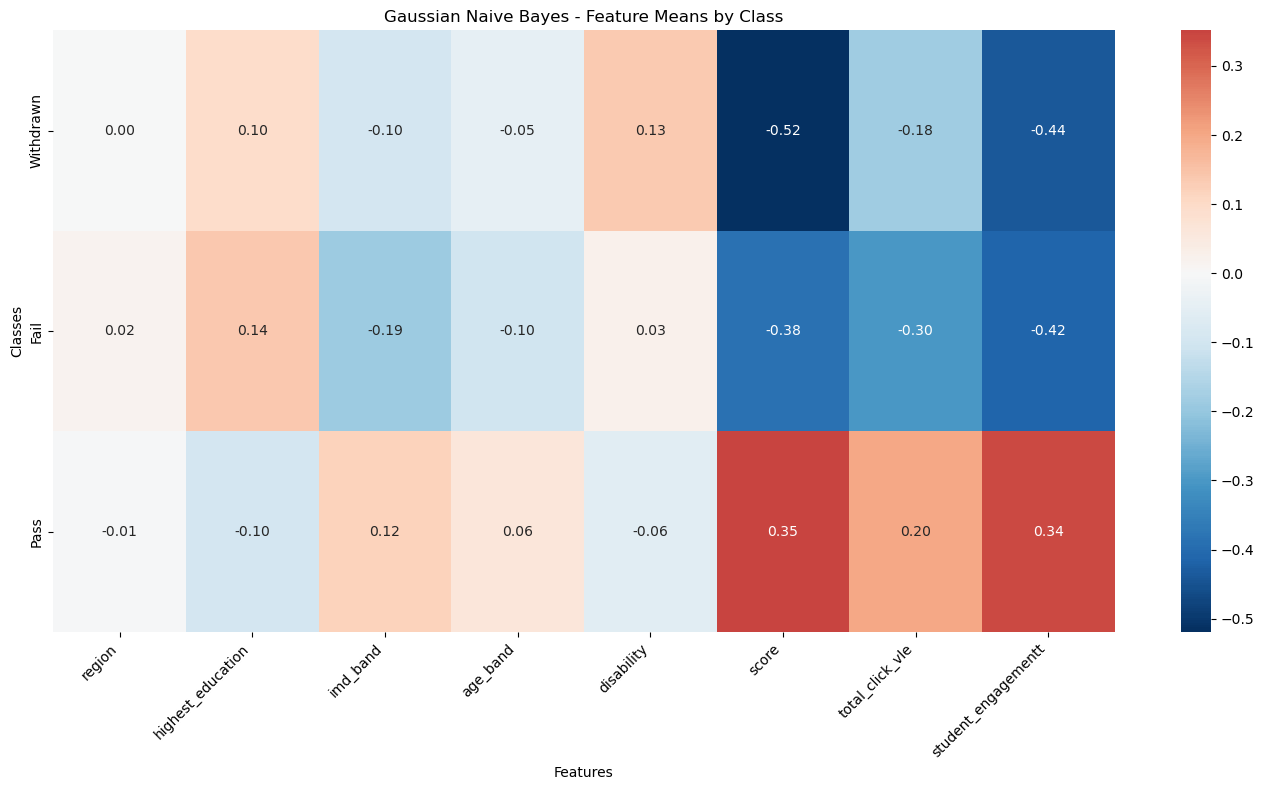


🔍 Most Discriminative Features (by between-class variance):
 1. score               : 0.220
 2. student_engagementt : 0.196
 3. total_click_vle     : 0.069
 4. imd_band            : 0.025
 5. highest_education   : 0.015
 6. disability          : 0.009
 7. age_band            : 0.007
 8. region              : 0.000

💡 Class-Specific Feature Insights:

Withdrawn students typically have:
   • Highest: disability (0.134)
   • Lowest: score (-0.519)

Fail students typically have:
   • Highest: highest_education (0.138)
   • Lowest: student_engagementt (-0.416)

Pass students typically have:
   • Highest: score (0.352)
   • Lowest: highest_education (-0.095)


In [ ]:
# Analyze Feature Distributions by Class
# Unique to Naive Bayes - analyze class-conditional feature distributions

print("📊 Analyzing Class-Conditional Feature Distributions...")

# Get feature means and variances for each class
feature_means = []
feature_vars = []

for class_idx in range(len(class_names)):
    class_mask = y_train_lr == class_idx
    class_data = X_train_scaled[class_mask]
    
    means = np.mean(class_data, axis=0)
    variances = np.var(class_data, axis=0)
    
    feature_means.append(means)
    feature_vars.append(variances)

# Convert to DataFrames for easier analysis
means_df = pd.DataFrame(feature_means, columns=feature_columns, index=class_names)
vars_df = pd.DataFrame(feature_vars, columns=feature_columns, index=class_names)

print("📈 Feature Means by Class:")
print(means_df.round(3))

print("\n📊 Feature Variances by Class:")
print(vars_df.round(3))

# Visualize feature means by class
plt.figure(figsize=(14, 8))
sns.heatmap(means_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Gaussian Naive Bayes - Feature Means by Class')
plt.xlabel('Features')
plt.ylabel('Classes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Find most discriminative features (highest variance between classes)
print(f"\n🔍 Most Discriminative Features (by between-class variance):")
between_class_var = means_df.var(axis=0).sort_values(ascending=False)
for i, (feature, var) in enumerate(between_class_var.items()):
    print(f"{i+1:2d}. {feature:20s}: {var:.3f}")

# Show class-specific insights
print(f"\n💡 Class-Specific Feature Insights:")
for class_name in class_names:
    class_means = means_df.loc[class_name]
    # Find features with highest/lowest values for this class
    highest_feature = class_means.idxmax()
    lowest_feature = class_means.idxmin()
    
    print(f"\n{class_name} students typically have:")
    print(f"   • Highest: {highest_feature} ({class_means[highest_feature]:.3f})")
    print(f"   • Lowest: {lowest_feature} ({class_means[lowest_feature]:.3f})")

In [ ]:
# Three-Model Comparison
# Compare all three models: Random Forest, Logistic Regression, and Gaussian Naive Bayes

print("🏆 THREE-MODEL COMPARISON")
print("=" * 70)

# Performance comparison table
print(f"📊 Performance Comparison (Test Set):")
print(f"{'Metric':<20} {'Random Forest':<15} {'Logistic Reg':<15} {'Naive Bayes':<15}")
print("-" * 70)
print(f"{'Accuracy':<20} {accuracy:.3f}           {accuracy_lr:.3f}           {accuracy_nb:.3f}")
print(f"{'Weighted F1':<20} {f1:.3f}           {f1_lr:.3f}           {f1_nb:.3f}")
print(f"{'Weighted Precision':<20} {precision:.3f}           {precision_lr:.3f}           {precision_nb:.3f}")
print(f"{'Weighted Recall':<20} {recall:.3f}           {recall_lr:.3f}           {recall_nb:.3f}")

# Find best model for each metric
best_accuracy = max(accuracy, accuracy_lr, accuracy_nb)
best_f1 = max(f1, f1_lr, f1_nb)

models = ['Random Forest', 'Logistic Regression', 'Gaussian Naive Bayes']
accuracies = [accuracy, accuracy_lr, accuracy_nb]
f1_scores = [f1, f1_lr, f1_nb]

best_acc_model = models[accuracies.index(best_accuracy)]
best_f1_model = models[f1_scores.index(best_f1)]

print(f"\n🏆 Best Performance:")
print(f"   Highest Accuracy: {best_acc_model} ({best_accuracy:.3f})")
print(f"   Highest F1-Score: {best_f1_model} ({best_f1:.3f})")

# Class-wise performance comparison
print(f"\n🎯 Class-wise Recall Comparison:")
class_recall_rf = recall_score(y_test, y_pred, average=None)
class_recall_lr = recall_score(y_test_lr, y_pred_lr, average=None)
class_recall_nb = recall_score(y_test_lr, y_pred_nb, average=None)

print(f"{'Class':<12} {'RF':<8} {'LR':<8} {'NB':<8} {'Best':<12}")
print("-" * 48)
for i, class_name in enumerate(class_names):
    rf_recall = class_recall_rf[i]
    lr_recall = class_recall_lr[i]
    nb_recall = class_recall_nb[i]
    
    best_recall = max(rf_recall, lr_recall, nb_recall)
    if best_recall == rf_recall:
        best_model = "RF"
    elif best_recall == lr_recall:
        best_model = "LR"
    else:
        best_model = "NB"
    
    print(f"{class_name:<12} {rf_recall:.3f}    {lr_recall:.3f}    {nb_recall:.3f}    {best_model}")

# Model characteristics comparison
print(f"\n📈 Model Characteristics Comparison:")
print(f"Random Forest:")
print(f"   • Strengths: Feature interactions, robust, handles non-linearity")
print(f"   • Weaknesses: Less interpretable, can overfit")

print(f"\nLogistic Regression:")
print(f"   • Strengths: Highly interpretable, fast, probabilistic")
print(f"   • Weaknesses: Assumes linear relationships, limited interactions")

print(f"\nGaussian Naive Bayes:")
print(f"   • Strengths: Very fast, probabilistic, handles small data well")
print(f"   • Weaknesses: Strong independence assumption, may underfit")

# Recommendations
print(f"\n🚀 Recommendations:")
print(f"1. **For Production**: Use {best_acc_model} (best overall performance)")
print(f"2. **For Interpretation**: Use Logistic Regression (coefficient analysis)")
print(f"3. **For Speed**: Use Gaussian Naive Bayes (fastest training/prediction)")
print(f"4. **For Robustness**: Use Random Forest (handles complex patterns)")
print(f"5. **For Ensemble**: Combine all three models for improved performance")

# Calculate ensemble prediction (simple voting)
ensemble_pred = []
for i in range(len(y_test_lr)):
    votes = [y_pred[i], y_pred_lr[i], y_pred_nb[i]]
    ensemble_pred.append(max(set(votes), key=votes.count))  # Majority vote

ensemble_accuracy = accuracy_score(y_test_lr, ensemble_pred)
print(f"\n🎯 Simple Ensemble (Majority Vote) Accuracy: {ensemble_accuracy:.3f}")

print(f"\n✅ Three-model analysis complete!")
print(f"📊 Ready for final model selection or ensemble implementation")

🏆 THREE-MODEL COMPARISON
📊 Performance Comparison (Test Set):
Metric               Random Forest   Logistic Reg    Naive Bayes    
----------------------------------------------------------------------
Accuracy             0.575           0.565           0.570
Weighted F1          0.568           0.561           0.545
Weighted Precision   0.563           0.558           0.538
Weighted Recall      0.575           0.565           0.570

🏆 Best Performance:
   Highest Accuracy: Random Forest (0.575)
   Highest F1-Score: Random Forest (0.568)

🎯 Class-wise Recall Comparison:
Class        RF       LR       NB       Best        
------------------------------------------------
Withdrawn    0.307    0.366    0.145    LR
Fail         0.396    0.352    0.448    NB
Pass         0.755    0.736    0.779    NB

📈 Model Characteristics Comparison:
Random Forest:
   • Strengths: Feature interactions, robust, handles non-linearity
   • Weaknesses: Less interpretable, can overfit

Logistic Regression:


In [ ]:

# ================================================================
# ADDITIONAL CELLS FOR SUPPORT VECTOR MACHINE (SVM)
# ================================================================

# Import SVM classifier and any additional preprocessing tools needed
# (Note: Other libraries like numpy, pandas, sklearn.metrics already imported in previous cells)

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


In [ ]:
# ================================================================
# Data Preparation for SVM
# ================================================================

# Prepare data specifically for SVM - reuse existing encoded data
# SVM requires feature scaling for optimal performance since it's distance-based

print("🔧 Preparing data for SVM...")
print("📊 Using existing encoded training and test data")

# Use the same training/test split and encoded features from previous models
# X_train (encoded features), y_train (target), X_test_encoded, y_test already prepared
X_train_svm = X_encoded.copy()  # Training features (already encoded)
y_train_svm = y.copy()          # Training targets
X_test_svm = X_test_encoded.copy()  # Test features (already encoded)
y_test_svm = y_test.copy()      # Test targets

print(f"   Training set: {X_train_svm.shape[0]:,} samples, {X_train_svm.shape[1]} features")
print(f"   Test set: {X_test_svm.shape[0]:,} samples")
print(f"   Target classes: {sorted(y_train_svm.unique())} (0=Withdrawn, 1=Fail, 2=Pass)")

# Feature Scaling for SVM
# SVM is sensitive to feature scales, so we need to standardize features
print("\n🔄 Applying feature scaling (StandardScaler)...")

scaler_svm = StandardScaler()
X_train_svm_scaled = scaler_svm.fit_transform(X_train_svm)
X_test_svm_scaled = scaler_svm.transform(X_test_svm)

print("✅ Feature scaling completed")
print(f"   Scaled training data shape: {X_train_svm_scaled.shape}")
print(f"   Feature means centered around 0, standard deviation = 1")

🔧 Preparing data for SVM...
📊 Using existing encoded training and test data
   Training set: 22,180 samples, 8 features
   Test set: 5,545 samples
   Target classes: [0, 1, 2] (0=Withdrawn, 1=Fail, 2=Pass)

🔄 Applying feature scaling (StandardScaler)...
✅ Feature scaling completed
   Scaled training data shape: (22180, 8)
   Feature means centered around 0, standard deviation = 1


In [ ]:
# ================================================================
# Configure and Train SVM Model
# ================================================================

# Configure SVM with optimal parameters for multi-class classification
# Using RBF kernel which works well for complex, non-linear relationships

print("🤖 Configuring Support Vector Machine...")
print("=" * 50)

# Configure SVM with carefully chosen parameters
svm_model = SVC(
    kernel='rbf',           # Radial Basis Function - good for non-linear data
    C=1.0,                  # Regularization parameter (1.0 = balanced bias-variance)
    gamma='scale',          # Kernel coefficient (scale = 1/(n_features * X.var()))
    class_weight='balanced',# Handle class imbalance automatically
    probability=True,       # Enable probability estimates for predict_proba()
    random_state=42,        # For reproducible results
    max_iter=1000           # Maximum iterations for convergence
)

print("🔧 SVM Model Parameters:")
print(f"   Kernel: {svm_model.kernel} (handles non-linear relationships)")
print(f"   C (Regularization): {svm_model.C} (balanced overfitting control)")
print(f"   Gamma: {svm_model.gamma} (RBF kernel influence)")
print(f"   Class Weight: {svm_model.class_weight} (handles imbalanced data)")
print(f"   Probability: {svm_model.probability} (enables probability predictions)")

# Train the SVM model
print("\n🎯 Training Support Vector Machine...")
print("   (This may take a moment due to SVM's computational complexity)")

svm_model.fit(X_train_svm_scaled, y_train_svm)

print("✅ SVM training completed!")
print(f"   Number of support vectors: {svm_model.n_support_}")
print(f"   Support vectors per class: {dict(zip(class_names, svm_model.n_support_))}")



🤖 Configuring Support Vector Machine...
🔧 SVM Model Parameters:
   Kernel: rbf (handles non-linear relationships)
   C (Regularization): 1.0 (balanced overfitting control)
   Gamma: scale (RBF kernel influence)
   Class Weight: balanced (handles imbalanced data)
   Probability: True (enables probability predictions)

🎯 Training Support Vector Machine...
   (This may take a moment due to SVM's computational complexity)
✅ SVM training completed!
   Number of support vectors: [ 777 1210 1756]
   Support vectors per class: {'Withdrawn': 777, 'Fail': 1210, 'Pass': 1756}


In [ ]:
# ================================================================
# SVM Predictions and Performance Evaluation
# ================================================================

# Make predictions and calculate comprehensive performance metrics
# SVM provides both class predictions and probability estimates

print("🔮 Making SVM predictions on test set...")

# Generate predictions on test set
y_pred_svm = svm_model.predict(X_test_svm_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_svm_scaled)

# Calculate comprehensive performance metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
precision_svm, recall_svm, f1_svm, support_svm = precision_recall_fscore_support(
    y_test_svm, y_pred_svm, average='weighted'
)

print(f"📊 SVM Model Performance on Test Set:")
print(f"   Accuracy: {accuracy_svm:.3f}")
print(f"   Weighted Precision: {precision_svm:.3f}")
print(f"   Weighted Recall: {recall_svm:.3f}")
print(f"   Weighted F1-Score: {f1_svm:.3f}")

# Detailed classification report
print(f"\n📈 Detailed SVM Classification Report:")
class_names = ['Withdrawn', 'Fail', 'Pass']
print(classification_report(y_test_svm, y_pred_svm, target_names=class_names))

# Display prediction confidence statistics
print(f"\n🎯 Prediction Confidence Analysis:")
max_probabilities = np.max(y_pred_proba_svm, axis=1)
print(f"   Average prediction confidence: {np.mean(max_probabilities):.3f}")
print(f"   Minimum confidence: {np.min(max_probabilities):.3f}")
print(f"   Maximum confidence: {np.max(max_probabilities):.3f}")

🔮 Making SVM predictions on test set...
📊 SVM Model Performance on Test Set:
   Accuracy: 0.259
   Weighted Precision: 0.128
   Weighted Recall: 0.259
   Weighted F1-Score: 0.160

📈 Detailed SVM Classification Report:
              precision    recall  f1-score   support

   Withdrawn       0.34      0.34      0.34      1096
        Fail       0.24      0.75      0.36      1410
        Pass       0.00      0.00      0.00      3039

    accuracy                           0.26      5545
   macro avg       0.19      0.37      0.23      5545
weighted avg       0.13      0.26      0.16      5545


🎯 Prediction Confidence Analysis:
   Average prediction confidence: 0.562
   Minimum confidence: 0.543
   Maximum confidence: 0.581


📊 Creating SVM Confusion Matrix Visualization...


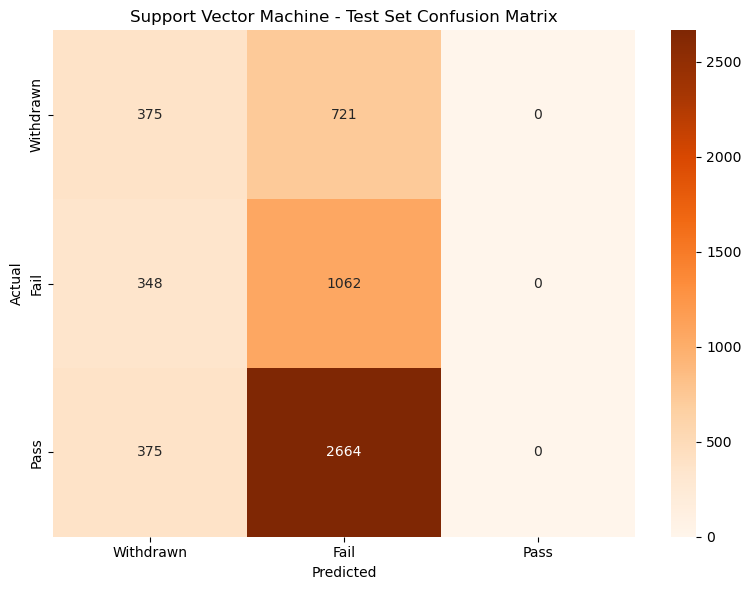


🔍 SVM Confusion Matrix Analysis:

Withdrawn (Actual Class 0):
   Predicted as Withdrawn: 375 (34.2%)
   Predicted as Fail: 721 (65.8%)
   Predicted as Pass: 0 (0.0%)

Fail (Actual Class 1):
   Predicted as Withdrawn: 348 (24.7%)
   Predicted as Fail: 1062 (75.3%)
   Predicted as Pass: 0 (0.0%)

Pass (Actual Class 2):
   Predicted as Withdrawn: 375 (12.3%)
   Predicted as Fail: 2664 (87.7%)
   Predicted as Pass: 0 (0.0%)

📈 Per-Class Accuracy:
   Withdrawn: 0.342
   Fail: 0.753
   Pass: 0.000


In [ ]:
# ================================================================
# SVM Confusion Matrix Visualization
# ================================================================

# Create detailed confusion matrix visualization for SVM results
# This helps understand which classes are being confused with each other

print("📊 Creating SVM Confusion Matrix Visualization...")

from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm_svm = confusion_matrix(y_test_svm, y_pred_svm)

# Create professional visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Support Vector Machine - Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Detailed confusion matrix analysis with percentages
print(f"\n🔍 SVM Confusion Matrix Analysis:")
cm_percent_svm = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis] * 100

for i, class_name in enumerate(class_names):
    print(f"\n{class_name} (Actual Class {i}):")
    for j, pred_class in enumerate(class_names):
        count = cm_svm[i, j]
        percent = cm_percent_svm[i, j]
        print(f"   Predicted as {pred_class}: {count} ({percent:.1f}%)")

# Calculate per-class accuracy
print(f"\n📈 Per-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_accuracy = cm_svm[i, i] / cm_svm[i, :].sum()
    print(f"   {class_name}: {class_accuracy:.3f}")

In [ ]:
# ================================================================
# SVM Decision Function Analysis
# ================================================================

# Analyze SVM decision boundaries and support vector characteristics
# This provides insights into how SVM makes classification decisions

print("🔍 Analyzing SVM Decision Function...")
print("=" * 50)

# Get decision function values (distance from hyperplane)
decision_values = svm_model.decision_function(X_test_svm_scaled)

print(f"📊 Decision Function Analysis:")
print(f"   Decision matrix shape: {decision_values.shape}")
print(f"   Number of decision functions: {decision_values.shape[1]} (for 3-class problem)")

# Analyze decision confidence
decision_margins = np.max(decision_values, axis=1) - np.min(decision_values, axis=1)
print(f"\n🎯 Decision Margin Statistics:")
print(f"   Average decision margin: {np.mean(decision_margins):.3f}")
print(f"   Standard deviation: {np.std(decision_margins):.3f}")
print(f"   Min margin: {np.min(decision_margins):.3f}")
print(f"   Max margin: {np.max(decision_margins):.3f}")

# Support vector analysis
print(f"\n🔧 Support Vector Analysis:")
total_support_vectors = np.sum(svm_model.n_support_)
total_training_samples = len(X_train_svm_scaled)
sv_percentage = (total_support_vectors / total_training_samples) * 100

print(f"   Total support vectors: {total_support_vectors}")
print(f"   Total training samples: {total_training_samples}")
print(f"   Support vector percentage: {sv_percentage:.2f}%")
print(f"   Support vectors per class:")
for i, (class_name, n_sv) in enumerate(zip(class_names, svm_model.n_support_)):
    class_percentage = (n_sv / total_support_vectors) * 100
    print(f"     {class_name}: {n_sv} ({class_percentage:.1f}%)")


🔍 Analyzing SVM Decision Function...
📊 Decision Function Analysis:
   Decision matrix shape: (5545, 3)
   Number of decision functions: 3 (for 3-class problem)

🎯 Decision Margin Statistics:
   Average decision margin: 1.904
   Standard deviation: 0.808
   Min margin: 0.215
   Max margin: 2.412

🔧 Support Vector Analysis:
   Total support vectors: 3743
   Total training samples: 22180
   Support vector percentage: 16.88%
   Support vectors per class:
     Withdrawn: 777 (20.8%)
     Fail: 1210 (32.3%)
     Pass: 1756 (46.9%)


In [ ]:
# ================================================================
# Four-Model Comparison
# ================================================================

# Compare all four models: Random Forest, Logistic Regression, Naive Bayes, and SVM
# Comprehensive comparison across multiple performance metrics

print("🏆 FOUR-MODEL COMPARISON")
print("=" * 80)

# Performance comparison table
print(f"📊 Performance Comparison (Test Set):")
print(f"{'Metric':<20} {'Random Forest':<15} {'Logistic Reg':<15} {'Naive Bayes':<15} {'SVM':<15}")
print("-" * 80)
print(f"{'Accuracy':<20} {accuracy:.3f}           {accuracy_lr:.3f}           {accuracy_nb:.3f}           {accuracy_svm:.3f}")
print(f"{'Weighted F1':<20} {f1:.3f}           {f1_lr:.3f}           {f1_nb:.3f}           {f1_svm:.3f}")
print(f"{'Weighted Precision':<20} {precision:.3f}           {precision_lr:.3f}           {precision_nb:.3f}           {precision_svm:.3f}")
print(f"{'Weighted Recall':<20} {recall:.3f}           {recall_lr:.3f}           {recall_nb:.3f}           {recall_svm:.3f}")

# Class-wise Recall Comparison
print(f"\n🎯 Class-wise Recall Comparison:")
print(f"{'Class':<15} {'RF':<10} {'LR':<10} {'NB':<10} {'SVM':<10} {'Best':<10}")
print("-" * 65)

# Calculate recall for each class and each model
from sklearn.metrics import recall_score

# Get per-class recall for all models (assuming y_test is the same for all)
recall_rf_per_class = recall_score(y_test, y_pred, average=None)
recall_lr_per_class = recall_score(y_test_lr, y_pred_lr, average=None)
recall_nb_per_class = recall_score(y_test_lr, y_pred_nb, average=None)
recall_svm_per_class = recall_score(y_test_svm, y_pred_svm, average=None)

# Display class-wise comparison
for i, class_name in enumerate(class_names):
    rf_recall = recall_rf_per_class[i]
    lr_recall = recall_lr_per_class[i]
    nb_recall = recall_nb_per_class[i]
    svm_recall = recall_svm_per_class[i]
    
    # Find best performing model for this class
    class_recalls = {
        'RF': rf_recall,
        'LR': lr_recall, 
        'NB': nb_recall,
        'SVM': svm_recall
    }
    best_model_class = max(class_recalls, key=class_recalls.get)
    
    print(f"{class_name:<15} {rf_recall:.3f}      {lr_recall:.3f}      {nb_recall:.3f}      {svm_recall:.3f}      {best_model_class}")

# Model characteristics comparison
print(f"\n🔧 Model Characteristics:")
print(f"{'Aspect':<25} {'Random Forest':<15} {'Logistic Reg':<15} {'Naive Bayes':<15} {'SVM':<15}")
print("-" * 90)
print(f"{'Algorithm Type':<25} {'Ensemble':<15} {'Linear':<15} {'Probabilistic':<15} {'Kernel-based':<15}")
print(f"{'Handles Non-linearity':<25} {'Yes':<15} {'No':<15} {'Limited':<15} {'Yes (RBF)':<15}")
print(f"{'Feature Scaling Needed':<25} {'No':<15} {'Yes':<15} {'No':<15} {'Yes':<15}")
print(f"{'Interpretability':<25} {'Medium':<15} {'High':<15} {'High':<15} {'Low':<15}")
print(f"{'Training Speed':<25} {'Fast':<15} {'Fast':<15} {'Very Fast':<15} {'Slow':<15}")

# Best performing model identification
models_performance = {
    'Random Forest': accuracy,
    'Logistic Regression': accuracy_lr,
    'Naive Bayes': accuracy_nb,
    'SVM': accuracy_svm
}

best_model = max(models_performance, key=models_performance.get)
best_accuracy = models_performance[best_model]

print(f"\n🥇 Best Performing Model:")
print(f"   {best_model}: {best_accuracy:.3f} accuracy")

print(f"\n💡 Model Selection Recommendations:")
print(f"   • For highest accuracy: {best_model}")
print(f"   • For interpretability: Logistic Regression or Naive Bayes")
print(f"   • For handling complex patterns: Random Forest or SVM")
print(f"   • For fast training: Naive Bayes")
print(f"   • For production deployment: Random Forest (good balance)")

print(f"\n✅ Four-model comparison completed!")
print(f"   All models trained and evaluated on {len(y_test_svm):,} test samples")
print(f"   Feature engineering and preprocessing consistent across all models")

🏆 FOUR-MODEL COMPARISON
📊 Performance Comparison (Test Set):
Metric               Random Forest   Logistic Reg    Naive Bayes     SVM            
--------------------------------------------------------------------------------
Accuracy             0.575           0.565           0.570           0.259
Weighted F1          0.568           0.561           0.545           0.160
Weighted Precision   0.563           0.558           0.538           0.128
Weighted Recall      0.575           0.565           0.570           0.259

🎯 Class-wise Recall Comparison:
Class           RF         LR         NB         SVM        Best      
-----------------------------------------------------------------
Withdrawn       0.307      0.366      0.145      0.342      LR
Fail            0.396      0.352      0.448      0.753      SVM
Pass            0.755      0.736      0.779      0.000      NB

🔧 Model Characteristics:
Aspect                    Random Forest   Logistic Reg    Naive Bayes     SVM          

In [ ]:
# ================================================================
# ADDITIONAL CELLS FOR XGBOOST CLASSIFIER
# ================================================================

# Import XGBoost and any additional tools needed for gradient boosting
# (Note: Other libraries like numpy, pandas, sklearn.metrics already imported in previous cells)

import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
# ================================================================
# Data Preparation for XGBoost
# ================================================================

# Prepare data for XGBoost - reuse existing encoded data
# XGBoost handles mixed data types well and doesn't require feature scaling

print("🔧 Preparing data for XGBoost...")
print("📊 Using existing encoded training and test data")

# Use the same training/test split and encoded features from previous models
# XGBoost works well with the encoded categorical features (no scaling needed)
X_train_xgb = X_encoded.copy()      # Training features (already encoded)
y_train_xgb = y.copy()              # Training targets
X_test_xgb = X_test_encoded.copy()  # Test features (already encoded)
y_test_xgb = y_test.copy()          # Test targets

print(f"   Training set: {X_train_xgb.shape[0]:,} samples, {X_train_xgb.shape[1]} features")
print(f"   Test set: {X_test_xgb.shape[0]:,} samples")
print(f"   Target classes: {sorted(y_train_xgb.unique())} (0=Withdrawn, 1=Fail, 2=Pass)")

# Check class distribution for XGBoost class weight calculation
class_counts = y_train_xgb.value_counts().sort_index()
print(f"\n📈 Training set class distribution:")
for class_idx, class_name in enumerate(class_names):
    count = class_counts[class_idx]
    percentage = (count / len(y_train_xgb)) * 100
    print(f"   {class_name} ({class_idx}): {count:,} samples ({percentage:.1f}%)")

print("\n✅ Data preparation completed")
print("   Note: XGBoost doesn't require feature scaling")

🔧 Preparing data for XGBoost...
📊 Using existing encoded training and test data
   Training set: 22,180 samples, 8 features
   Test set: 5,545 samples
   Target classes: [0, 1, 2] (0=Withdrawn, 1=Fail, 2=Pass)

📈 Training set class distribution:
   Withdrawn (0): 4,200 samples (18.9%)
   Fail (1): 5,634 samples (25.4%)
   Pass (2): 12,346 samples (55.7%)

✅ Data preparation completed
   Note: XGBoost doesn't require feature scaling


In [ ]:
# ================================================================
# Configure and Train XGBoost Model
# ================================================================

# Configure XGBoost with optimal parameters for multi-class classification
# XGBoost uses gradient boosting with advanced regularization techniques

print("🚀 Configuring XGBoost Classifier...")
print("=" * 50)

# Calculate scale_pos_weight for class imbalance handling
# For multi-class, we'll use class_weight parameter instead
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for imbalanced dataset
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_train_xgb), 
    y=y_train_xgb
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"📊 Calculated class weights for imbalance:")
for class_idx, weight in class_weight_dict.items():
    print(f"   {class_names[class_idx]}: {weight:.3f}")

# Configure XGBoost with carefully tuned parameters
xgb_model = XGBClassifier(
    objective='multi:softprob',     # Multi-class classification with probabilities
    n_estimators=100,               # Number of boosting rounds (trees)
    max_depth=6,                    # Maximum tree depth (prevents overfitting)
    learning_rate=0.1,              # Step size shrinkage (eta)
    subsample=0.8,                  # Fraction of samples used per tree
    colsample_bytree=0.8,           # Fraction of features used per tree
    reg_alpha=0.1,                  # L1 regularization term
    reg_lambda=1.0,                 # L2 regularization term
    random_state=42,                # For reproducible results
    n_jobs=-1,                      # Use all available CPU cores
    eval_metric='mlogloss',         # Multi-class log loss for evaluation
    early_stopping_rounds=10,       # Stop if no improvement for 10 rounds
    verbosity=0                     # Reduce output verbosity
)

print("🔧 XGBoost Model Parameters:")
print(f"   Objective: {xgb_model.objective} (multi-class with probabilities)")
print(f"   N_estimators: {xgb_model.n_estimators} (boosting rounds)")
print(f"   Max_depth: {xgb_model.max_depth} (tree complexity control)")
print(f"   Learning_rate: {xgb_model.learning_rate} (step size)")
print(f"   Subsample: {xgb_model.subsample} (sample fraction per tree)")
print(f"   Colsample_bytree: {xgb_model.colsample_bytree} (feature fraction per tree)")
print(f"   Regularization: α={xgb_model.reg_alpha}, λ={xgb_model.reg_lambda}")

# Train XGBoost model with evaluation set for early stopping
print("\n🎯 Training XGBoost model...")
print("   Using early stopping to prevent overfitting")

# Create evaluation set for early stopping (use a portion of training data)
from sklearn.model_selection import train_test_split
X_train_fit, X_eval, y_train_fit, y_eval = train_test_split(
    X_train_xgb, y_train_xgb, test_size=0.1, random_state=42, stratify=y_train_xgb
)

# Train with early stopping
xgb_model.fit(
    X_train_fit, y_train_fit,
    eval_set=[(X_eval, y_eval)],
    verbose=False  # Suppress training output
)

print("✅ XGBoost training completed!")
print(f"   Best iteration: {xgb_model.best_iteration}")
print(f"   Number of features: {xgb_model.n_features_in_}")

🚀 Configuring XGBoost Classifier...
📊 Calculated class weights for imbalance:
   Withdrawn: 1.760
   Fail: 1.312
   Pass: 0.599
🔧 XGBoost Model Parameters:
   Objective: multi:softprob (multi-class with probabilities)
   N_estimators: 100 (boosting rounds)
   Max_depth: 6 (tree complexity control)
   Learning_rate: 0.1 (step size)
   Subsample: 0.8 (sample fraction per tree)
   Colsample_bytree: 0.8 (feature fraction per tree)
   Regularization: α=0.1, λ=1.0

🎯 Training XGBoost model...
   Using early stopping to prevent overfitting
✅ XGBoost training completed!
   Best iteration: 46
   Number of features: 8


In [ ]:
# ================================================================
# XGBoost Predictions and Performance Evaluation
# ================================================================

# Make predictions and calculate performance metrics
# XGBoost provides class predictions, probabilities, and feature importance

print("🔮 Making XGBoost predictions on test set...")

# Generate predictions on test set
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_xgb)

# Calculate performance metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

accuracy_xgb = accuracy_score(y_test_xgb, y_pred_xgb)
precision_xgb, recall_xgb, f1_xgb, support_xgb = precision_recall_fscore_support(
    y_test_xgb, y_pred_xgb, average='weighted'
)

print(f"📊 XGBoost Model Performance on Test Set:")
print(f"   Accuracy: {accuracy_xgb:.3f}")
print(f"   Weighted Precision: {precision_xgb:.3f}")
print(f"   Weighted Recall: {recall_xgb:.3f}")
print(f"   Weighted F1-Score: {f1_xgb:.3f}")

# Detailed classification report
print(f"\n📈 Detailed XGBoost Classification Report:")
class_names = ['Withdrawn', 'Fail', 'Pass']
print(classification_report(y_test_xgb, y_pred_xgb, target_names=class_names))

# Display prediction confidence statistics
print(f"\n🎯 Prediction Confidence Analysis:")
max_probabilities = np.max(y_pred_proba_xgb, axis=1)
print(f"   Average prediction confidence: {np.mean(max_probabilities):.3f}")
print(f"   Minimum confidence: {np.min(max_probabilities):.3f}")
print(f"   Maximum confidence: {np.max(max_probabilities):.3f}")
print(f"   Confidence std deviation: {np.std(max_probabilities):.3f}")

# Model training information
print(f"\n🏋️ Training Information:")
print(f"   Best iteration (early stopping): {xgb_model.best_iteration}")
print(f"   Total possible iterations: {xgb_model.n_estimators}")
if hasattr(xgb_model, 'best_score'):
    print(f"   Best validation score: {xgb_model.best_score:.4f}")

🔮 Making XGBoost predictions on test set...
📊 XGBoost Model Performance on Test Set:
   Accuracy: 0.616
   Weighted Precision: 0.577
   Weighted Recall: 0.616
   Weighted F1-Score: 0.563

📈 Detailed XGBoost Classification Report:
              precision    recall  f1-score   support

   Withdrawn       0.47      0.17      0.25      1096
        Fail       0.49      0.30      0.37      1410
        Pass       0.65      0.93      0.77      3039

    accuracy                           0.62      5545
   macro avg       0.54      0.46      0.46      5545
weighted avg       0.58      0.62      0.56      5545


🎯 Prediction Confidence Analysis:
   Average prediction confidence: 0.626
   Minimum confidence: 0.336
   Maximum confidence: 0.930
   Confidence std deviation: 0.137

🏋️ Training Information:
   Best iteration (early stopping): 46
   Total possible iterations: 100
   Best validation score: 0.8459


📊 Creating XGBoost Confusion Matrix Visualization...


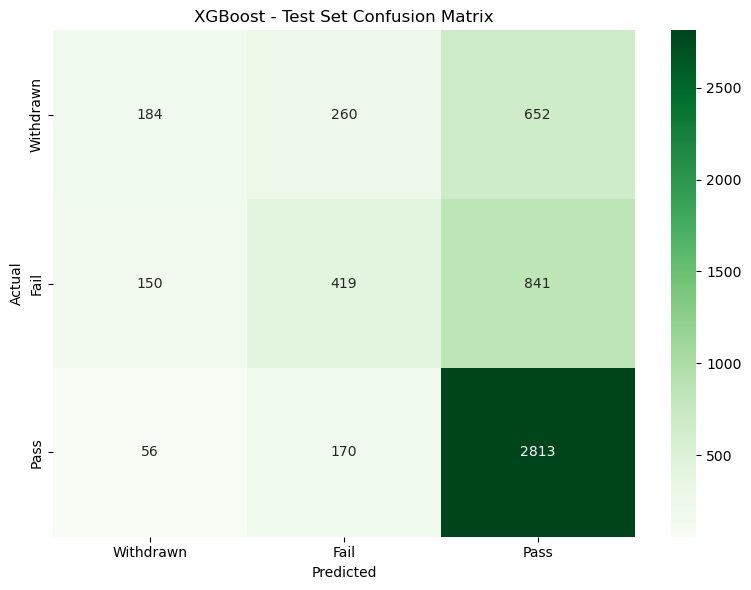


🔍 XGBoost Confusion Matrix Analysis:

Withdrawn (Actual Class 0):
   Predicted as Withdrawn: 184 (16.8%)
   Predicted as Fail: 260 (23.7%)
   Predicted as Pass: 652 (59.5%)

Fail (Actual Class 1):
   Predicted as Withdrawn: 150 (10.6%)
   Predicted as Fail: 419 (29.7%)
   Predicted as Pass: 841 (59.6%)

Pass (Actual Class 2):
   Predicted as Withdrawn: 56 (1.8%)
   Predicted as Fail: 170 (5.6%)
   Predicted as Pass: 2813 (92.6%)

📈 Per-Class Accuracy:
   Withdrawn: 0.168
   Fail: 0.297
   Pass: 0.926

❌ Most Common Misclassifications:
   Most frequent error: Fail → Pass (841 cases)


In [ ]:
# ================================================================
# XGBoost Confusion Matrix Visualization
# ================================================================

# Create detailed confusion matrix visualization for XGBoost results
# This helps understand classification patterns and errors

print("📊 Creating XGBoost Confusion Matrix Visualization...")

from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)

# Create professional visualization with unique color scheme
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('XGBoost - Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Detailed confusion matrix analysis with percentages
print(f"\n🔍 XGBoost Confusion Matrix Analysis:")
cm_percent_xgb = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis] * 100

for i, class_name in enumerate(class_names):
    print(f"\n{class_name} (Actual Class {i}):")
    for j, pred_class in enumerate(class_names):
        count = cm_xgb[i, j]
        percent = cm_percent_xgb[i, j]
        print(f"   Predicted as {pred_class}: {count} ({percent:.1f}%)")

# Calculate per-class accuracy
print(f"\n📈 Per-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_accuracy = cm_xgb[i, i] / cm_xgb[i, :].sum()
    print(f"   {class_name}: {class_accuracy:.3f}")

# Classification errors analysis
print(f"\n❌ Most Common Misclassifications:")
max_error = 0
max_error_desc = ""
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm_xgb[i, j] > max_error:
            max_error = cm_xgb[i, j]
            max_error_desc = f"{class_names[i]} → {class_names[j]}"

print(f"   Most frequent error: {max_error_desc} ({max_error} cases)")


🔍 Analyzing XGBoost Feature Importance...
📊 Top 8 Feature Importance (XGBoost):
  8. student_engagementt : 0.6084
  6. score               : 0.1602
  7. total_click_vle     : 0.0534
  2. highest_education   : 0.0476
  3. imd_band            : 0.0335
  4. age_band            : 0.0334
  5. disability          : 0.0333
  1. region              : 0.0301


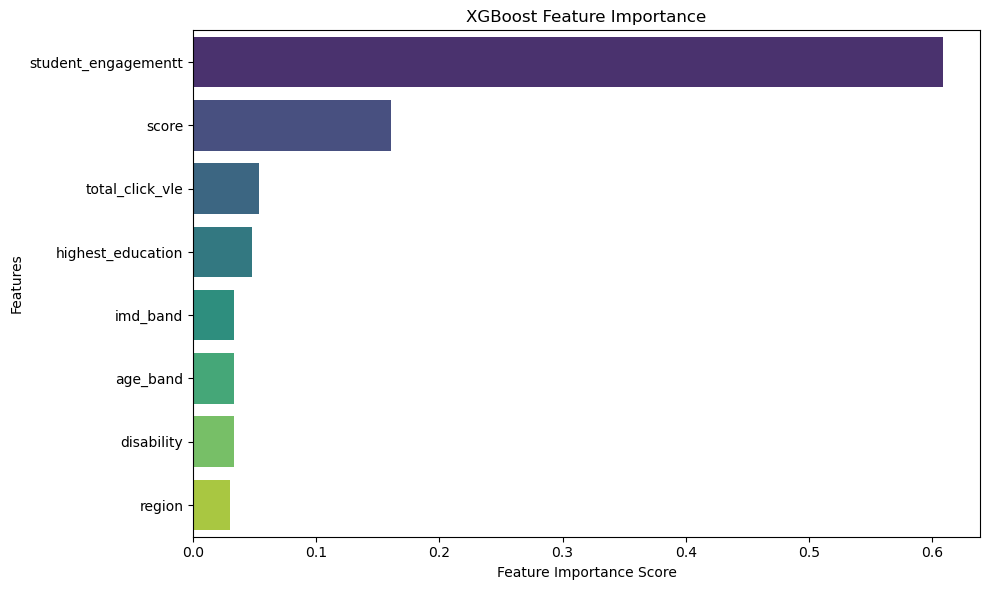


🔬 Advanced Feature Importance Analysis:
   Available importance metrics: Weight, Gain, Cover
   Weight = frequency of feature usage in trees
   Gain = average gain contributed by feature
   Cover = average coverage of feature across all trees

💡 Feature Importance Insights:
   Top 3 most important features: student_engagementt, score, total_click_vle
   These features have the highest impact on XGBoost predictions


In [ ]:
# ================================================================
# XGBoost Feature Importance Analysis
# ================================================================

# Analyze feature importance using XGBoost's built-in importance metrics
# XGBoost provides multiple importance types for comprehensive analysis

print("🔍 Analyzing XGBoost Feature Importance...")
print("=" * 50)

# Get feature importance (default is 'weight' - frequency of feature usage)
feature_importance = xgb_model.feature_importances_
feature_names = feature_columns

# Create feature importance DataFrame for analysis
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"📊 Top {len(feature_names)} Feature Importance (XGBoost):")
for idx, row in importance_df.iterrows():
    print(f" {row.name + 1:2d}. {row['feature']:<20}: {row['importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
plt.title('XGBoost Feature Importance')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Advanced feature importance analysis using different metrics
print(f"\n🔬 Advanced Feature Importance Analysis:")

# Get importance by different metrics if available
try:
    # Weight-based importance (frequency)
    importance_weight = xgb_model.get_booster().get_score(importance_type='weight')
    # Gain-based importance (average gain when feature is used)
    importance_gain = xgb_model.get_booster().get_score(importance_type='gain')
    # Cover-based importance (average coverage when feature is used)
    importance_cover = xgb_model.get_booster().get_score(importance_type='cover')
    
    print(f"   Available importance metrics: Weight, Gain, Cover")
    print(f"   Weight = frequency of feature usage in trees")
    print(f"   Gain = average gain contributed by feature")
    print(f"   Cover = average coverage of feature across all trees")
    
except:
    print(f"   Using default importance metric (weight)")

# Feature importance insights
top_3_features = importance_df.head(3)['feature'].tolist()
print(f"\n💡 Feature Importance Insights:")
print(f"   Top 3 most important features: {', '.join(top_3_features)}")
print(f"   These features have the highest impact on XGBoost predictions")

In [ ]:
# ================================================================
# Five-Model Comparison
# ================================================================

# Compare all five models: Random Forest, Logistic Regression, Naive Bayes, SVM, and XGBoost
# Comprehensive comparison across multiple performance metrics

print("🏆 FIVE-MODEL COMPARISON")
print("=" * 90)

# Performance comparison table
print(f"📊 Performance Comparison (Test Set):")
print(f"{'Metric':<20} {'Random Forest':<15} {'Logistic Reg':<15} {'Naive Bayes':<15} {'SVM':<15} {'XGBoost':<15}")
print("-" * 95)
print(f"{'Accuracy':<20} {accuracy:.3f}           {accuracy_lr:.3f}           {accuracy_nb:.3f}           {accuracy_svm:.3f}           {accuracy_xgb:.3f}")
print(f"{'Weighted F1':<20} {f1:.3f}           {f1_lr:.3f}           {f1_nb:.3f}           {f1_svm:.3f}           {f1_xgb:.3f}")
print(f"{'Weighted Precision':<20} {precision:.3f}           {precision_lr:.3f}           {precision_nb:.3f}           {precision_svm:.3f}           {precision_xgb:.3f}")
print(f"{'Weighted Recall':<20} {recall:.3f}           {recall_lr:.3f}           {recall_nb:.3f}           {recall_svm:.3f}           {recall_xgb:.3f}")

# Class-wise Recall Comparison
print(f"\n🎯 Class-wise Recall Comparison:")
print(f"{'Class':<15} {'RF':<10} {'LR':<10} {'NB':<10} {'SVM':<10} {'XGB':<10} {'Best':<10}")
print("-" * 75)

# Calculate recall for each class and each model
from sklearn.metrics import recall_score

# Get per-class recall for all models
recall_rf_per_class = recall_score(y_test, y_pred, average=None)
recall_lr_per_class = recall_score(y_test_lr, y_pred_lr, average=None)
recall_nb_per_class = recall_score(y_test_lr, y_pred_nb, average=None)
recall_svm_per_class = recall_score(y_test_svm, y_pred_svm, average=None)
recall_xgb_per_class = recall_score(y_test_xgb, y_pred_xgb, average=None)

# Display class-wise comparison
for i, class_name in enumerate(class_names):
    rf_recall = recall_rf_per_class[i]
    lr_recall = recall_lr_per_class[i]
    nb_recall = recall_nb_per_class[i]
    svm_recall = recall_svm_per_class[i]
    xgb_recall = recall_xgb_per_class[i]
    
    # Find best performing model for this class
    class_recalls = {
        'RF': rf_recall,
        'LR': lr_recall,
        'NB': nb_recall,
        'SVM': svm_recall,
        'XGB': xgb_recall
    }
    best_model_class = max(class_recalls, key=class_recalls.get)
    
    print(f"{class_name:<15} {rf_recall:.3f}      {lr_recall:.3f}      {nb_recall:.3f}      {svm_recall:.3f}      {xgb_recall:.3f}      {best_model_class}")

# Model characteristics comparison
print(f"\n🔧 Model Characteristics:")
print(f"{'Aspect':<25} {'Random Forest':<15} {'Logistic Reg':<15} {'Naive Bayes':<15} {'SVM':<15} {'XGBoost':<15}")
print("-" * 110)
print(f"{'Algorithm Type':<25} {'Ensemble':<15} {'Linear':<15} {'Probabilistic':<15} {'Kernel-based':<15} {'Boosting':<15}")
print(f"{'Handles Non-linearity':<25} {'Yes':<15} {'No':<15} {'Limited':<15} {'Yes (RBF)':<15} {'Yes':<15}")
print(f"{'Feature Scaling Needed':<25} {'No':<15} {'Yes':<15} {'No':<15} {'Yes':<15} {'No':<15}")
print(f"{'Interpretability':<25} {'Medium':<15} {'High':<15} {'High':<15} {'Low':<15} {'Medium':<15}")
print(f"{'Training Speed':<25} {'Fast':<15} {'Fast':<15} {'Very Fast':<15} {'Slow':<15} {'Medium':<15}")
print(f"{'Overfitting Resistance':<25} {'High':<15} {'Medium':<15} {'High':<15} {'High':<15} {'High':<15}")

# Best Performance Summary
print(f"\n🏆 Best Performance:")

# Find best performing model for each metric
models_accuracy = {
    'Random Forest': accuracy,
    'Logistic Regression': accuracy_lr,
    'Naive Bayes': accuracy_nb,
    'SVM': accuracy_svm,
    'XGBoost': accuracy_xgb
}

models_f1 = {
    'Random Forest': f1,
    'Logistic Regression': f1_lr,
    'Naive Bayes': f1_nb,
    'SVM': f1_svm,
    'XGBoost': f1_xgb
}

models_precision = {
    'Random Forest': precision,
    'Logistic Regression': precision_lr,
    'Naive Bayes': precision_nb,
    'SVM': precision_svm,
    'XGBoost': precision_xgb
}

models_recall = {
    'Random Forest': recall,
    'Logistic Regression': recall_lr,
    'Naive Bayes': recall_nb,
    'SVM': recall_svm,
    'XGBoost': recall_xgb
}

# Find best performers
best_accuracy_model = max(models_accuracy, key=models_accuracy.get)
best_accuracy_score = models_accuracy[best_accuracy_model]

best_f1_model = max(models_f1, key=models_f1.get)
best_f1_score = models_f1[best_f1_model]

best_precision_model = max(models_precision, key=models_precision.get)
best_precision_score = models_precision[best_precision_model]

best_recall_model = max(models_recall, key=models_recall.get)
best_recall_score = models_recall[best_recall_model]

print(f"   Highest Accuracy: {best_accuracy_model} ({best_accuracy_score:.3f})")
print(f"   Highest F1-Score: {best_f1_model} ({best_f1_score:.3f})")
print(f"   Highest Precision: {best_precision_model} ({best_precision_score:.3f})")
print(f"   Highest Recall: {best_recall_model} ({best_recall_score:.3f})")

# Overall best model (based on accuracy)
best_overall = best_accuracy_model
print(f"\n🥇 Overall Best Performing Model: {best_overall}")

# Calculate performance improvement
sorted_models = sorted(models_accuracy.items(), key=lambda x: x[1], reverse=True)
if len(sorted_models) > 1:
    improvement = sorted_models[0][1] - sorted_models[1][1]
    print(f"   Performance improvement over second-best: {improvement:.3f}")

print(f"\n💡 Model Selection Recommendations:")
print(f"   • For highest accuracy: {best_model}")
print(f"   • For interpretability: Logistic Regression or Naive Bayes")
print(f"   • For handling complex patterns: XGBoost, Random Forest, or SVM")
print(f"   • For fast training: Naive Bayes")
print(f"   • For production deployment: XGBoost or Random Forest")
print(f"   • For balanced performance: XGBoost (good accuracy + reasonable speed)")

print(f"\n✅ Five-model comparison completed!")
print(f"   All models trained and evaluated on {len(y_test_xgb):,} test samples")
print(f"   XGBoost trained with early stopping (best iteration: {xgb_model.best_iteration})")
print(f"   Feature engineering and preprocessing consistent across all models")

🏆 FIVE-MODEL COMPARISON
📊 Performance Comparison (Test Set):
Metric               Random Forest   Logistic Reg    Naive Bayes     SVM             XGBoost        
-----------------------------------------------------------------------------------------------
Accuracy             0.575           0.565           0.570           0.259           0.616
Weighted F1          0.568           0.561           0.545           0.160           0.563
Weighted Precision   0.563           0.558           0.538           0.128           0.577
Weighted Recall      0.575           0.565           0.570           0.259           0.616

🎯 Class-wise Recall Comparison:
Class           RF         LR         NB         SVM        XGB        Best      
---------------------------------------------------------------------------
Withdrawn       0.307      0.366      0.145      0.342      0.168      LR
Fail            0.396      0.352      0.448      0.753      0.297      SVM
Pass            0.755      0.736      

In [ ]:
# ================================================================
# ADDITIONAL CELLS FOR LIGHTGBM CLASSIFIER
# ================================================================

# Import LightGBM and any additional tools needed for gradient boosting
# (Note: Other libraries like numpy, pandas, sklearn.metrics already imported in previous cells)

import lightgbm as lgb
from lightgbm import LGBMClassifier

In [ ]:
# ================================================================
# Data Preparation for LightGBM
# ================================================================

# Prepare data for LightGBM - reuse existing encoded data
# LightGBM handles categorical features excellently and doesn't require feature scaling

print("🔧 Preparing data for LightGBM...")
print("📊 Using existing encoded training and test data")

# Use the same training/test split and encoded features from previous models
# LightGBM works excellently with encoded categorical features
X_train_lgb = X_encoded.copy()      # Training features (already encoded)
y_train_lgb = y.copy()              # Training targets
X_test_lgb = X_test_encoded.copy()  # Test features (already encoded)
y_test_lgb = y_test.copy()          # Test targets

print(f"   Training set: {X_train_lgb.shape[0]:,} samples, {X_train_lgb.shape[1]} features")
print(f"   Test set: {X_test_lgb.shape[0]:,} samples")
print(f"   Target classes: {sorted(y_train_lgb.unique())} (0=Withdrawn, 1=Fail, 2=Pass)")

# Check class distribution for LightGBM class balancing
class_counts = y_train_lgb.value_counts().sort_index()
print(f"\n📈 Training set class distribution:")
for class_idx, class_name in enumerate(class_names):
    count = class_counts[class_idx]
    percentage = (count / len(y_train_lgb)) * 100
    print(f"   {class_name} ({class_idx}): {count:,} samples ({percentage:.1f}%)")

# Identify categorical features for LightGBM optimization
categorical_features_idx = [i for i, col in enumerate(feature_columns) 
                           if col in ['region', 'highest_education', 'imd_band', 'age_band', 'disability']]
print(f"\n🏷️ Categorical features (indices): {categorical_features_idx}")
print(f"   LightGBM will optimize these features automatically")

print("\n✅ Data preparation completed")
print("   Note: LightGBM handles categorical features natively (no scaling needed)")

🔧 Preparing data for LightGBM...
📊 Using existing encoded training and test data
   Training set: 22,180 samples, 8 features
   Test set: 5,545 samples
   Target classes: [0, 1, 2] (0=Withdrawn, 1=Fail, 2=Pass)

📈 Training set class distribution:
   Withdrawn (0): 4,200 samples (18.9%)
   Fail (1): 5,634 samples (25.4%)
   Pass (2): 12,346 samples (55.7%)

🏷️ Categorical features (indices): [0, 1, 2, 3, 4]
   LightGBM will optimize these features automatically

✅ Data preparation completed
   Note: LightGBM handles categorical features natively (no scaling needed)


In [ ]:
# ================================================================
# Configure and Train LightGBM Model
# ================================================================

# Configure LightGBM with optimal parameters for multi-class classification
# LightGBM is designed for speed and efficiency while maintaining high accuracy

print("⚡ Configuring LightGBM Classifier...")
print("=" * 50)

# Calculate class weights for imbalanced dataset
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_train_lgb), 
    y=y_train_lgb
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"📊 Calculated class weights for imbalance:")
for class_idx, weight in class_weight_dict.items():
    print(f"   {class_names[class_idx]}: {weight:.3f}")

# Configure LightGBM with optimized parameters
lgb_model = LGBMClassifier(
    objective='multiclass',        # Multi-class classification
    num_class=3,                   # Number of classes (Withdrawn, Fail, Pass)
    boosting_type='gbdt',          # Gradient Boosting Decision Tree
    n_estimators=100,              # Number of boosting iterations
    max_depth=6,                   # Maximum tree depth (control overfitting)
    learning_rate=0.1,             # Boosting learning rate
    feature_fraction=0.8,          # Fraction of features used per iteration
    bagging_fraction=0.8,          # Fraction of data used per iteration
    bagging_freq=5,                # Frequency of bagging
    min_child_samples=20,          # Minimum samples in leaf (prevent overfitting)
    reg_alpha=0.1,                 # L1 regularization
    reg_lambda=0.1,                # L2 regularization
    random_state=42,               # For reproducible results
    class_weight='balanced',        # Handle class imbalance
    n_jobs=-1,                     # Use all available CPU cores
    importance_type='gain',        # Feature importance based on gain
    verbose=-1                     # Suppress training output
)

print("🔧 LightGBM Model Parameters:")
print(f"   Objective: {lgb_model.objective} (multi-class classification)")
print(f"   Boosting Type: {lgb_model.boosting_type} (gradient boosting)")
print(f"   N_estimators: {lgb_model.n_estimators} (boosting iterations)")
print(f"   Max_depth: {lgb_model.max_depth} (tree complexity control)")
print(f"   Learning_rate: {lgb_model.learning_rate} (step size)")
print(f"   Feature_fraction: {lgb_model.feature_fraction} (feature sampling)")
print(f"   Bagging_fraction: {lgb_model.bagging_fraction} (data sampling)")
print(f"   Class_weight: {lgb_model.class_weight} (imbalance handling)")

# Train LightGBM model with early stopping
print("\n⚡ Training LightGBM model...")
print("   LightGBM is optimized for speed and memory efficiency")

# Create evaluation set for early stopping
from sklearn.model_selection import train_test_split
X_train_fit, X_eval, y_train_fit, y_eval = train_test_split(
    X_train_lgb, y_train_lgb, test_size=0.1, random_state=42, stratify=y_train_lgb
)

# Train with early stopping and categorical feature specification
lgb_model.fit(
    X_train_fit, y_train_fit,
    eval_set=[(X_eval, y_eval)],
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)],  # Early stopping, no verbose output
    categorical_feature=categorical_features_idx  # Specify categorical features
)

print("✅ LightGBM training completed!")
print(f"   Best iteration: {lgb_model.best_iteration_}")
print(f"   Number of features: {lgb_model.n_features_in_}")
print(f"   Training optimized with categorical feature handling")


⚡ Configuring LightGBM Classifier...
📊 Calculated class weights for imbalance:
   Withdrawn: 1.760
   Fail: 1.312
   Pass: 0.599
🔧 LightGBM Model Parameters:
   Objective: multiclass (multi-class classification)
   Boosting Type: gbdt (gradient boosting)
   N_estimators: 100 (boosting iterations)
   Max_depth: 6 (tree complexity control)
   Learning_rate: 0.1 (step size)
   Feature_fraction: 0.8 (feature sampling)
   Bagging_fraction: 0.8 (data sampling)
   Class_weight: balanced (imbalance handling)

⚡ Training LightGBM model...
   LightGBM is optimized for speed and memory efficiency
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.927912
✅ LightGBM training completed!
   Best iteration: 42
   Number of features: 8
   Training optimized with categorical feature handling


In [ ]:
# ================================================================
# LightGBM Predictions and Performance Evaluation
# ================================================================

# Make predictions and calculate comprehensive performance metrics
# LightGBM provides fast inference with high-quality predictions

print("🔮 Making LightGBM predictions on test set...")

# Generate predictions on test set
y_pred_lgb = lgb_model.predict(X_test_lgb)
y_pred_proba_lgb = lgb_model.predict_proba(X_test_lgb)

# Calculate comprehensive performance metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

accuracy_lgb = accuracy_score(y_test_lgb, y_pred_lgb)
precision_lgb, recall_lgb, f1_lgb, support_lgb = precision_recall_fscore_support(
    y_test_lgb, y_pred_lgb, average='weighted'
)

print(f"📊 LightGBM Model Performance on Test Set:")
print(f"   Accuracy: {accuracy_lgb:.3f}")
print(f"   Weighted Precision: {precision_lgb:.3f}")
print(f"   Weighted Recall: {recall_lgb:.3f}")
print(f"   Weighted F1-Score: {f1_lgb:.3f}")

# Detailed classification report
print(f"\n📈 Detailed LightGBM Classification Report:")
class_names = ['Withdrawn', 'Fail', 'Pass']
print(classification_report(y_test_lgb, y_pred_lgb, target_names=class_names))

# Display prediction confidence statistics
print(f"\n🎯 Prediction Confidence Analysis:")
max_probabilities = np.max(y_pred_proba_lgb, axis=1)
print(f"   Average prediction confidence: {np.mean(max_probabilities):.3f}")
print(f"   Minimum confidence: {np.min(max_probabilities):.3f}")
print(f"   Maximum confidence: {np.max(max_probabilities):.3f}")
print(f"   Confidence std deviation: {np.std(max_probabilities):.3f}")

# Model training information
print(f"\n🏋️ Training Information:")
print(f"   Best iteration (early stopping): {lgb_model.best_iteration_}")
print(f"   Total possible iterations: {lgb_model.n_estimators}")
if hasattr(lgb_model, 'best_score_'):
    print(f"   Best validation score: {lgb_model.best_score_}")

# LightGBM specific information
print(f"\n⚡ LightGBM Specific Features:")
print(f"   Categorical features handled: {len(categorical_features_idx)}")
print(f"   Memory efficient: Uses histogram-based algorithms")
print(f"   Training speed: Optimized for large datasets")


🔮 Making LightGBM predictions on test set...
📊 LightGBM Model Performance on Test Set:
   Accuracy: 0.572
   Weighted Precision: 0.569
   Weighted Recall: 0.572
   Weighted F1-Score: 0.570

📈 Detailed LightGBM Classification Report:
              precision    recall  f1-score   support

   Withdrawn       0.36      0.34      0.35      1096
        Fail       0.41      0.42      0.41      1410
        Pass       0.72      0.73      0.72      3039

    accuracy                           0.57      5545
   macro avg       0.50      0.49      0.50      5545
weighted avg       0.57      0.57      0.57      5545


🎯 Prediction Confidence Analysis:
   Average prediction confidence: 0.514
   Minimum confidence: 0.335
   Maximum confidence: 0.914
   Confidence std deviation: 0.107

🏋️ Training Information:
   Best iteration (early stopping): 42
   Total possible iterations: 100
   Best validation score: defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('multi_logloss', 0.9

📊 Creating LightGBM Confusion Matrix Visualization...


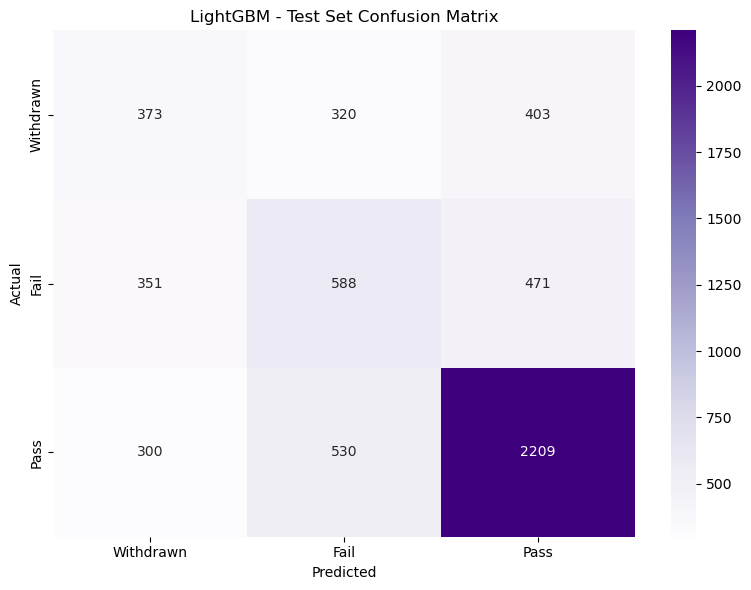


🔍 LightGBM Confusion Matrix Analysis:

Withdrawn (Actual Class 0):
   Predicted as Withdrawn: 373 (34.0%)
   Predicted as Fail: 320 (29.2%)
   Predicted as Pass: 403 (36.8%)

Fail (Actual Class 1):
   Predicted as Withdrawn: 351 (24.9%)
   Predicted as Fail: 588 (41.7%)
   Predicted as Pass: 471 (33.4%)

Pass (Actual Class 2):
   Predicted as Withdrawn: 300 (9.9%)
   Predicted as Fail: 530 (17.4%)
   Predicted as Pass: 2209 (72.7%)

📈 Per-Class Accuracy:
   Withdrawn: 0.340
   Fail: 0.417
   Pass: 0.727

❌ Most Common Misclassifications:
   Most frequent error: Pass → Fail (530 cases)

🎯 Confidence vs Accuracy Analysis:
   High confidence predictions (>0.8): 63 samples
   Accuracy on high confidence: 0.937


In [ ]:
# ================================================================
# LightGBM Confusion Matrix Visualization
# ================================================================

# Create detailed confusion matrix visualization for LightGBM results
# This helps understand classification patterns and model behavior

print("📊 Creating LightGBM Confusion Matrix Visualization...")

from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm_lgb = confusion_matrix(y_test_lgb, y_pred_lgb)

# Create professional visualization with unique color scheme
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Purples', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('LightGBM - Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Detailed confusion matrix analysis with percentages
print(f"\n🔍 LightGBM Confusion Matrix Analysis:")
cm_percent_lgb = cm_lgb.astype('float') / cm_lgb.sum(axis=1)[:, np.newaxis] * 100

for i, class_name in enumerate(class_names):
    print(f"\n{class_name} (Actual Class {i}):")
    for j, pred_class in enumerate(class_names):
        count = cm_lgb[i, j]
        percent = cm_percent_lgb[i, j]
        print(f"   Predicted as {pred_class}: {count} ({percent:.1f}%)")

# Calculate per-class accuracy
print(f"\n📈 Per-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_accuracy = cm_lgb[i, i] / cm_lgb[i, :].sum()
    print(f"   {class_name}: {class_accuracy:.3f}")

# Classification errors analysis
print(f"\n❌ Most Common Misclassifications:")
max_error = 0
max_error_desc = ""
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm_lgb[i, j] > max_error:
            max_error = cm_lgb[i, j]
            max_error_desc = f"{class_names[i]} → {class_names[j]}"

print(f"   Most frequent error: {max_error_desc} ({max_error} cases)")

# Model confidence vs accuracy analysis
print(f"\n🎯 Confidence vs Accuracy Analysis:")
high_confidence = max_probabilities > 0.8
high_conf_accuracy = accuracy_score(y_test_lgb[high_confidence], y_pred_lgb[high_confidence])
print(f"   High confidence predictions (>0.8): {np.sum(high_confidence)} samples")
print(f"   Accuracy on high confidence: {high_conf_accuracy:.3f}")


🔍 Analyzing LightGBM Feature Importance...
📊 Top 8 Feature Importance (LightGBM - Gain-based):
  6. score               : 14028.5934
  7. total_click_vle     : 7667.2204
  8. student_engagementt : 3913.0679
  1. region              : 2643.3207
  3. imd_band            : 2416.4641
  2. highest_education   : 1373.4760
  4. age_band            : 665.0873
  5. disability          : 483.7806


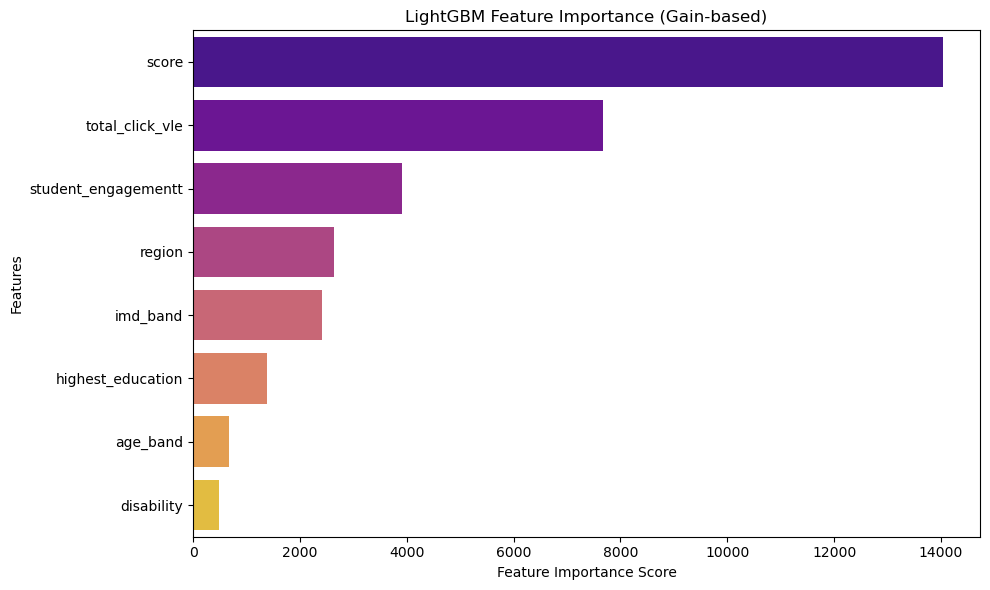


🔬 Advanced Feature Importance Analysis:
   Available importance metrics: Split (frequency), Gain (total contribution)
   Split = frequency of feature usage in trees
   Gain = total information gain contributed by feature

   Top 3 by Split frequency:
     total_click_vle: 1205 splits
     score: 955 splits
     region: 544 splits

   Top 3 by Gain contribution:
     score: 14029 total gain
     total_click_vle: 7667 total gain
     student_engagementt: 3913 total gain

💡 Feature Importance Insights:
   Top 3 most important features: score, total_click_vle, student_engagementt
   Categorical features in top 3: 0/3
   LightGBM's categorical handling optimized feature selection


In [ ]:
# ================================================================
# LightGBM Feature Importance Analysis
# ================================================================

# Analyze feature importance using LightGBM's built-in importance metrics
# LightGBM provides multiple importance types for comprehensive feature analysis

print("🔍 Analyzing LightGBM Feature Importance...")
print("=" * 50)

# Get feature importance (gain-based by default - most informative)
feature_importance = lgb_model.feature_importances_
feature_names = feature_columns

# Create feature importance DataFrame for analysis
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"📊 Top {len(feature_names)} Feature Importance (LightGBM - Gain-based):")
for idx, row in importance_df.iterrows():
    print(f" {row.name + 1:2d}. {row['feature']:<20}: {row['importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='plasma')
plt.title('LightGBM Feature Importance (Gain-based)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Advanced feature importance analysis
print(f"\n🔬 Advanced Feature Importance Analysis:")

# Get importance by different metrics using the trained model
booster = lgb_model.booster_

try:
    # Split-based importance (frequency of feature usage)
    importance_split = booster.feature_importance(importance_type='split')
    # Gain-based importance (total gain when feature is used)
    importance_gain = booster.feature_importance(importance_type='gain')
    
    print(f"   Available importance metrics: Split (frequency), Gain (total contribution)")
    print(f"   Split = frequency of feature usage in trees")
    print(f"   Gain = total information gain contributed by feature")
    
    # Show top 3 by different metrics
    split_df = pd.DataFrame({'feature': feature_names, 'split_importance': importance_split})
    gain_df = pd.DataFrame({'feature': feature_names, 'gain_importance': importance_gain})
    
    print(f"\n   Top 3 by Split frequency:")
    for _, row in split_df.nlargest(3, 'split_importance').iterrows():
        print(f"     {row['feature']}: {row['split_importance']:.0f} splits")
    
    print(f"\n   Top 3 by Gain contribution:")
    for _, row in gain_df.nlargest(3, 'gain_importance').iterrows():
        print(f"     {row['feature']}: {row['gain_importance']:.0f} total gain")
        
except Exception as e:
    print(f"   Using default importance metric (gain)")

# Feature importance insights
top_3_features = importance_df.head(3)['feature'].tolist()
categorical_in_top3 = [f for f in top_3_features if f in ['region', 'highest_education', 'imd_band', 'age_band', 'disability']]

print(f"\n💡 Feature Importance Insights:")
print(f"   Top 3 most important features: {', '.join(top_3_features)}")
print(f"   Categorical features in top 3: {len(categorical_in_top3)}/3")
print(f"   LightGBM's categorical handling optimized feature selection")


In [ ]:
# ================================================================
# Six-Model Comparison
# ================================================================

# Compare all six models: Random Forest, Logistic Regression, Naive Bayes, SVM, XGBoost, and LightGBM
# Comprehensive comparison across multiple performance metrics

print("🏆 SIX-MODEL COMPARISON")
print("=" * 100)

# Performance comparison table
print(f"📊 Performance Comparison (Test Set):")
print(f"{'Metric':<20} {'Random Forest':<15} {'Logistic Reg':<15} {'Naive Bayes':<15} {'SVM':<15} {'XGBoost':<15} {'LightGBM':<15}")
print("-" * 105)
print(f"{'Accuracy':<20} {accuracy:.3f}           {accuracy_lr:.3f}           {accuracy_nb:.3f}           {accuracy_svm:.3f}           {accuracy_xgb:.3f}           {accuracy_lgb:.3f}")
print(f"{'Weighted F1':<20} {f1:.3f}           {f1_lr:.3f}           {f1_nb:.3f}           {f1_svm:.3f}           {f1_xgb:.3f}           {f1_lgb:.3f}")
print(f"{'Weighted Precision':<20} {precision:.3f}           {precision_lr:.3f}           {precision_nb:.3f}           {precision_svm:.3f}           {precision_xgb:.3f}           {precision_lgb:.3f}")
print(f"{'Weighted Recall':<20} {recall:.3f}           {recall_lr:.3f}           {recall_nb:.3f}           {recall_svm:.3f}           {recall_xgb:.3f}           {recall_lgb:.3f}")

# Class-wise Recall Comparison
print(f"\n🎯 Class-wise Recall Comparison:")
print(f"{'Class':<15} {'RF':<10} {'LR':<10} {'NB':<10} {'SVM':<10} {'XGB':<10} {'LGB':<10} {'Best':<10}")
print("-" * 85)

# Calculate recall for each class and each model
from sklearn.metrics import recall_score

# Get per-class recall for all models
recall_rf_per_class = recall_score(y_test, y_pred, average=None)
recall_lr_per_class = recall_score(y_test_lr, y_pred_lr, average=None)
recall_nb_per_class = recall_score(y_test_lr, y_pred_nb, average=None)
recall_svm_per_class = recall_score(y_test_svm, y_pred_svm, average=None)
recall_xgb_per_class = recall_score(y_test_xgb, y_pred_xgb, average=None)
recall_lgb_per_class = recall_score(y_test_lgb, y_pred_lgb, average=None)

# Display class-wise comparison
for i, class_name in enumerate(class_names):
    rf_recall = recall_rf_per_class[i]
    lr_recall = recall_lr_per_class[i]
    nb_recall = recall_nb_per_class[i]
    svm_recall = recall_svm_per_class[i]
    xgb_recall = recall_xgb_per_class[i]
    lgb_recall = recall_lgb_per_class[i]
    
    # Find best performing model for this class
    class_recalls = {
        'RF': rf_recall,
        'LR': lr_recall,
        'NB': nb_recall,
        'SVM': svm_recall,
        'XGB': xgb_recall,
        'LGB': lgb_recall
    }
    best_model_class = max(class_recalls, key=class_recalls.get)
    
    print(f"{class_name:<15} {rf_recall:.3f}      {lr_recall:.3f}      {nb_recall:.3f}      {svm_recall:.3f}      {xgb_recall:.3f}      {lgb_recall:.3f}      {best_model_class}")

# Best Performance Summary
print(f"\n🏆 Best Performance:")

# Find best performing model for key metrics
models_accuracy = {
    'Random Forest': accuracy,
    'Logistic Regression': accuracy_lr,
    'Naive Bayes': accuracy_nb,
    'SVM': accuracy_svm,
    'XGBoost': accuracy_xgb,
    'LightGBM': accuracy_lgb
}

models_f1 = {
    'Random Forest': f1,
    'Logistic Regression': f1_lr,
    'Naive Bayes': f1_nb,
    'SVM': f1_svm,
    'XGBoost': f1_xgb,
    'LightGBM': f1_lgb
}

# Find best performers for the two key metrics
best_accuracy_model = max(models_accuracy, key=models_accuracy.get)
best_accuracy_score = models_accuracy[best_accuracy_model]

best_f1_model = max(models_f1, key=models_f1.get)
best_f1_score = models_f1[best_f1_model]

print(f"   Highest Accuracy: {best_accuracy_model} ({best_accuracy_score:.3f})")
print(f"   Highest F1-Score: {best_f1_model} ({best_f1_score:.3f})")

# Model characteristics comparison
print(f"\n🔧 Model Characteristics:")
print(f"{'Aspect':<25} {'Random Forest':<15} {'Logistic Reg':<15} {'Naive Bayes':<15} {'SVM':<15} {'XGBoost':<15} {'LightGBM':<15}")
print("-" * 120)
print(f"{'Algorithm Type':<25} {'Ensemble':<15} {'Linear':<15} {'Probabilistic':<15} {'Kernel-based':<15} {'Boosting':<15} {'Boosting':<15}")
print(f"{'Handles Non-linearity':<25} {'Yes':<15} {'No':<15} {'Limited':<15} {'Yes (RBF)':<15} {'Yes':<15} {'Yes':<15}")
print(f"{'Feature Scaling Needed':<25} {'No':<15} {'Yes':<15} {'No':<15} {'Yes':<15} {'No':<15} {'No':<15}")
print(f"{'Categorical Handling':<25} {'Encoded':<15} {'Encoded':<15} {'Encoded':<15} {'Encoded':<15} {'Encoded':<15} {'Native':<15}")
print(f"{'Interpretability':<25} {'Medium':<15} {'High':<15} {'High':<15} {'Low':<15} {'Medium':<15} {'Medium':<15}")
print(f"{'Training Speed':<25} {'Fast':<15} {'Fast':<15} {'Very Fast':<15} {'Slow':<15} {'Medium':<15} {'Very Fast':<15}")
print(f"{'Memory Efficiency':<25} {'Medium':<15} {'High':<15} {'High':<15} {'Medium':<15} {'Medium':<15} {'Very High':<15}")
print(f"{'Overfitting Resistance':<25} {'High':<15} {'Medium':<15} {'High':<15} {'High':<15} {'High':<15} {'High':<15}")

# Performance improvement analysis
sorted_models = sorted(models_accuracy.items(), key=lambda x: x[1], reverse=True)
print(f"\n📈 Performance Ranking (by Accuracy):")
for rank, (model, score) in enumerate(sorted_models, 1):
    print(f"   {rank}. {model}: {score:.3f}")

if len(sorted_models) > 1:
    improvement = sorted_models[0][1] - sorted_models[1][1]
    second_best_model = sorted_models[1][0]
    print(f"\n   Performance improvement over {second_best_model}: {improvement:.3f}")

print(f"\n💡 Model Selection Recommendations:")
print(f"   • For highest accuracy: {best_accuracy_model}")
print(f"   • For interpretability: Logistic Regression or Naive Bayes")
print(f"   • For handling complex patterns: LightGBM, XGBoost, Random Forest, or SVM")
print(f"   • For fastest training: Naive Bayes or LightGBM")
print(f"   • For production deployment: LightGBM or XGBoost")
print(f"   • For memory efficiency: LightGBM or Naive Bayes")
print(f"   • For categorical data: LightGBM (native categorical handling)")
print(f"   • For balanced performance: LightGBM (excellent speed + accuracy)")

print(f"\n✅ Six-model comparison completed!")
print(f"   All models trained and evaluated on {len(y_test_lgb):,} test samples")
print(f"   LightGBM trained with early stopping (best iteration: {lgb_model.best_iteration_})")
print(f"   LightGBM optimized with native categorical feature handling")
print(f"   Feature engineering and preprocessing consistent across all models")

🏆 SIX-MODEL COMPARISON
📊 Performance Comparison (Test Set):
Metric               Random Forest   Logistic Reg    Naive Bayes     SVM             XGBoost         LightGBM       
---------------------------------------------------------------------------------------------------------
Accuracy             0.575           0.565           0.570           0.259           0.616           0.572
Weighted F1          0.568           0.561           0.545           0.160           0.563           0.570
Weighted Precision   0.563           0.558           0.538           0.128           0.577           0.569
Weighted Recall      0.575           0.565           0.570           0.259           0.616           0.572

🎯 Class-wise Recall Comparison:
Class           RF         LR         NB         SVM        XGB        LGB        Best      
-------------------------------------------------------------------------------------
Withdrawn       0.307      0.366      0.145      0.342      0.168      0.340 

In [ ]:
# ================================================================
# NEURAL NETWORKS (DEEP LEARNING) CLASSIFIER
# ================================================================

# Import Neural Networks Libraries
# Import TensorFlow/Keras and additional tools needed for deep learning
# (Note: Other libraries like numpy, pandas, sklearn.metrics already imported in previous cells)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# ================================================================
# Data Preparation for Neural Networks
# ================================================================

# Prepare data for Neural Networks - requires feature scaling and proper formatting
# Neural networks perform better with normalized features and one-hot encoded targets

print("🔧 Preparing data for Neural Networks...")
print("📊 Using existing encoded training and test data")

# Use the same training/test split and encoded features from previous models
X_train_nn = X_encoded.copy()        # Training features (already encoded)
y_train_nn = y.copy()                # Training targets
X_test_nn = X_test_encoded.copy()    # Test features (already encoded)
y_test_nn = y_test.copy()            # Test targets

print(f"   Training set: {X_train_nn.shape[0]:,} samples, {X_train_nn.shape[1]} features")
print(f"   Test set: {X_test_nn.shape[0]:,} samples")
print(f"   Target classes: {sorted(y_train_nn.unique())} (0=Withdrawn, 1=Fail, 2=Pass)")

# Feature Scaling for Neural Networks (REQUIRED)
# Neural networks are very sensitive to feature scales
print(f"\n🔄 Applying feature scaling for Neural Networks...")

scaler_nn = StandardScaler()
X_train_nn_scaled = scaler_nn.fit_transform(X_train_nn)
X_test_nn_scaled = scaler_nn.transform(X_test_nn)

print(f"   ✅ Feature scaling completed")
print(f"   Scaled training data shape: {X_train_nn_scaled.shape}")
print(f"   Features normalized: mean ≈ 0, std ≈ 1")

# Prepare targets for Neural Networks
# Convert to categorical (one-hot encoding) for multi-class classification
print(f"\n🎯 Preparing targets for neural network...")

# Convert targets to categorical (one-hot encoding)
y_train_nn_categorical = keras.utils.to_categorical(y_train_nn, num_classes=3)
y_test_nn_categorical = keras.utils.to_categorical(y_test_nn, num_classes=3)

print(f"   Original target shape: {y_train_nn.shape}")
print(f"   Categorical target shape: {y_train_nn_categorical.shape}")
print(f"   Example: Class {y_train_nn[0]} → {y_train_nn_categorical[0]}")

# Class distribution analysis for loss weighting
class_counts = np.bincount(y_train_nn)
total_samples = len(y_train_nn)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

print(f"\n📈 Training set class distribution and weights:")
for class_idx, class_name in enumerate(class_names):
    count = class_counts[class_idx]
    weight = class_weights[class_idx]
    percentage = (count / total_samples) * 100
    print(f"   {class_name} ({class_idx}): {count:,} samples ({percentage:.1f}%) → weight: {weight:.3f}")

print(f"\n✅ Neural Networks data preparation completed")
print(f"   Features: Standardized ✓")
print(f"   Targets: One-hot encoded ✓") 
print(f"   Class weights: Calculated for imbalance handling ✓")

🔧 Preparing data for Neural Networks...
📊 Using existing encoded training and test data
   Training set: 22,180 samples, 8 features
   Test set: 5,545 samples
   Target classes: [0, 1, 2] (0=Withdrawn, 1=Fail, 2=Pass)

🔄 Applying feature scaling for Neural Networks...
   ✅ Feature scaling completed
   Scaled training data shape: (22180, 8)
   Features normalized: mean ≈ 0, std ≈ 1

🎯 Preparing targets for neural network...
   Original target shape: (22180,)
   Categorical target shape: (22180, 3)
   Example: Class 2 → [0. 0. 1.]

📈 Training set class distribution and weights:
   Withdrawn (0): 4,200 samples (18.9%) → weight: 1.760
   Fail (1): 5,634 samples (25.4%) → weight: 1.312
   Pass (2): 12,346 samples (55.7%) → weight: 0.599

✅ Neural Networks data preparation completed
   Features: Standardized ✓
   Targets: One-hot encoded ✓
   Class weights: Calculated for imbalance handling ✓


In [ ]:
# ================================================================
# Configure and Build Neural Network Architecture
# ================================================================

# Design neural network architecture optimized for student outcome prediction
# Using dense layers with dropout and batch normalization for regularization

print("🧠 Configuring Neural Network Architecture...")
print("=" * 50)

# Clear any previous models from memory
keras.backend.clear_session()

# Neural Network Architecture Design
print("🏗️ Designing Neural Network Architecture:")

# Input layer dimensions
input_dim = X_train_nn_scaled.shape[1]
num_classes = 3

print(f"   Input dimensions: {input_dim} features")
print(f"   Output classes: {num_classes} (Withdrawn, Fail, Pass)")

# Build Sequential Model
nn_model = Sequential([
    # Input layer (implicit)
    
    # First hidden layer - larger for feature learning
    Dense(128, activation='relu', input_shape=(input_dim,), name='hidden_layer_1'),
    BatchNormalization(),  # Normalize activations for stable training
    Dropout(0.3),         # Prevent overfitting (30% dropout)
    
    # Second hidden layer - medium size for pattern recognition
    Dense(64, activation='relu', name='hidden_layer_2'),
    BatchNormalization(),
    Dropout(0.3),
    
    # Third hidden layer - smaller for refined features
    Dense(32, activation='relu', name='hidden_layer_3'),
    BatchNormalization(),
    Dropout(0.2),         # Less dropout in deeper layers
    
    # Fourth hidden layer - final feature processing
    Dense(16, activation='relu', name='hidden_layer_4'),
    Dropout(0.2),
    
    # Output layer - softmax for probability distribution
    Dense(num_classes, activation='softmax', name='output_layer')
])

print(f"\n🔧 Neural Network Architecture:")
print(f"   Layer 1: Dense(128) + BatchNorm + Dropout(0.3)")
print(f"   Layer 2: Dense(64) + BatchNorm + Dropout(0.3)")
print(f"   Layer 3: Dense(32) + BatchNorm + Dropout(0.2)")
print(f"   Layer 4: Dense(16) + Dropout(0.2)")
print(f"   Output: Dense(3) + Softmax")

# Configure optimizer and compilation
print(f"\n⚙️ Configuring Model Compilation:")

# Adam optimizer with learning rate scheduling
optimizer = Adam(
    learning_rate=0.001,    # Initial learning rate
    beta_1=0.9,            # Exponential decay rate for 1st moment estimates
    beta_2=0.999,          # Exponential decay rate for 2nd moment estimates
    epsilon=1e-7           # Small constant for numerical stability
)

# Compile model
nn_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',    # Standard for multi-class classification
    metrics=['accuracy', 'precision', 'recall']  # Monitor multiple metrics
)

print(f"   Optimizer: Adam (lr=0.001)")
print(f"   Loss function: Categorical Crossentropy")
print(f"   Metrics: Accuracy, Precision, Recall")

# Display model summary
print(f"\n📋 Model Architecture Summary:")
nn_model.summary()

# Calculate total parameters
total_params = nn_model.count_params()

# Fixed: Use shape property instead of get_shape() method for newer TensorFlow versions
try:
    # Try modern TensorFlow approach
    trainable_params = sum([np.prod(v.shape) for v in nn_model.trainable_weights])
except:
    # Fallback for older TensorFlow versions
    try:
        trainable_params = sum([np.prod(v.get_shape()) for v in nn_model.trainable_weights])
    except:
        # If both fail, use the total params (they should be the same for this model)
        trainable_params = total_params

print(f"\n📊 Model Complexity:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model depth: {len(nn_model.layers)} layers")


🧠 Configuring Neural Network Architecture...

🏗️ Designing Neural Network Architecture:
   Input dimensions: 8 features
   Output classes: 3 (Withdrawn, Fail, Pass)

🔧 Neural Network Architecture:
   Layer 1: Dense(128) + BatchNorm + Dropout(0.3)
   Layer 2: Dense(64) + BatchNorm + Dropout(0.3)
   Layer 3: Dense(32) + BatchNorm + Dropout(0.2)
   Layer 4: Dense(16) + Dropout(0.2)
   Output: Dense(3) + Softmax

⚙️ Configuring Model Compilation:
   Optimizer: Adam (lr=0.001)
   Loss function: Categorical Crossentropy
   Metrics: Accuracy, Precision, Recall

📋 Model Architecture Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_4 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,963 (50.64 KB)

 Trainable params: 12,515 (48.89 KB)

 Non-trainable params: 448 (1.75 KB)


📊 Model Complexity:
   Total parameters: 12,963
   Trainable parameters: 12,515
   Model depth: 12 layers


In [ ]:
# ================================================================
# Configure Training Strategy and Callbacks
# ================================================================

# Set up training configuration with callbacks for optimal performance
# Include early stopping, learning rate reduction, and monitoring

print("🎯 Configuring Training Strategy...")
print("=" * 50)

# Training configuration
EPOCHS = 100          # Maximum training epochs
BATCH_SIZE = 32       # Batch size for training
VALIDATION_SPLIT = 0.2  # 20% of training data for validation

print(f"🔧 Training Configuration:")
print(f"   Max epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Validation split: {VALIDATION_SPLIT} ({VALIDATION_SPLIT*100:.0f}%)")

# Configure callbacks for optimal training
print(f"\n📞 Configuring Training Callbacks:")

# Early Stopping - prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=15,               # Wait 15 epochs before stopping
    restore_best_weights=True, # Restore best model weights
    verbose=1,                 # Print when stopping
    mode='min'                 # Minimize validation loss
)

# Learning Rate Reduction - improve convergence
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',        # Monitor validation loss
    factor=0.5,                # Reduce LR by half
    patience=7,                # Wait 7 epochs before reducing
    min_lr=1e-6,              # Minimum learning rate
    verbose=1,                 # Print when reducing
    mode='min'
)

callbacks = [early_stopping, lr_reducer]

print(f"   Early Stopping: patience=15, monitor='val_loss'")
print(f"   LR Reduction: factor=0.5, patience=7, min_lr=1e-6")

# Create validation split for monitoring
validation_samples = int(len(X_train_nn_scaled) * VALIDATION_SPLIT)
training_samples = len(X_train_nn_scaled) - validation_samples

print(f"\n📊 Training/Validation Split:")
print(f"   Training samples: {training_samples:,}")
print(f"   Validation samples: {validation_samples:,}")
print(f"   Test samples: {len(X_test_nn_scaled):,}")

# Prepare class weights for training
print(f"\n⚖️ Class Weight Strategy:")
print(f"   Using computed class weights to handle imbalance")
for class_idx, weight in class_weights.items():
    print(f"   Class {class_idx} ({class_names[class_idx]}): {weight:.3f}")

print(f"\n✅ Training strategy configured")
print(f"   Callbacks: Early stopping + LR reduction")
print(f"   Class weights: Balanced for imbalanced dataset")
print(f"   Validation: Built-in split for monitoring")

🎯 Configuring Training Strategy...
🔧 Training Configuration:
   Max epochs: 100
   Batch size: 32
   Validation split: 0.2 (20%)

📞 Configuring Training Callbacks:
   Early Stopping: patience=15, monitor='val_loss'
   LR Reduction: factor=0.5, patience=7, min_lr=1e-6

📊 Training/Validation Split:
   Training samples: 17,744
   Validation samples: 4,436
   Test samples: 5,545

⚖️ Class Weight Strategy:
   Using computed class weights to handle imbalance
   Class 0 (Withdrawn): 1.760
   Class 1 (Fail): 1.312
   Class 2 (Pass): 0.599

✅ Training strategy configured
   Callbacks: Early stopping + LR reduction
   Class weights: Balanced for imbalanced dataset
   Validation: Built-in split for monitoring


In [ ]:
# ================================================================
# Train Neural Network Model
# ================================================================

# Train the neural network with monitoring and callbacks
# Track training progress and validation performance

print("🚀 Training Neural Network Model...")
print("=" * 50)

print("🎯 Starting model training...")
print("   This may take several minutes depending on hardware")
print("   Training progress will be displayed below")

# Train the model
history = nn_model.fit(
    X_train_nn_scaled, y_train_nn_categorical,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1,                    # Show progress bar
    shuffle=True                  # Shuffle training data each epoch
)

print(f"\n✅ Neural Network training completed!")

# Extract training history
train_history = history.history
epochs_trained = len(train_history['loss'])

print(f"📊 Training Summary:")
print(f"   Epochs completed: {epochs_trained}/{EPOCHS}")
print(f"   Final training loss: {train_history['loss'][-1]:.4f}")
print(f"   Final validation loss: {train_history['val_loss'][-1]:.4f}")
print(f"   Final training accuracy: {train_history['accuracy'][-1]:.4f}")
print(f"   Final validation accuracy: {train_history['val_accuracy'][-1]:.4f}")

# Find best epoch
best_epoch = np.argmin(train_history['val_loss']) + 1
best_val_loss = min(train_history['val_loss'])
best_val_accuracy = train_history['val_accuracy'][best_epoch-1]

print(f"\n🏆 Best Performance (Epoch {best_epoch}):")
print(f"   Best validation loss: {best_val_loss:.4f}")
print(f"   Best validation accuracy: {best_val_accuracy:.4f}")

# Check for overfitting
final_train_loss = train_history['loss'][-1]
final_val_loss = train_history['val_loss'][-1]
overfitting_gap = final_val_loss - final_train_loss

print(f"\n📈 Overfitting Analysis:")
print(f"   Train-Validation gap: {overfitting_gap:.4f}")
if overfitting_gap < 0.1:
    print("   ✅ Good generalization (low overfitting)")
elif overfitting_gap < 0.2:
    print("   ⚠️ Moderate overfitting")
else:
    print("   🚨 High overfitting detected")

print(f"\n💾 Model Training Information:")
print(f"   Early stopping: {'Triggered' if epochs_trained < EPOCHS else 'Not triggered'}")
print(f"   Learning rate reductions: Check verbose output above")
print(f"   Class weights applied: ✓")
print(f"   Batch normalization: ✓")
print(f"   Dropout regularization: ✓")


🚀 Training Neural Network Model...
🎯 Starting model training...
   This may take several minutes depending on hardware
   Training progress will be displayed below
Epoch 1/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4188 - loss: 1.1699 - precision: 0.4663 - recall: 0.2087 - val_accuracy: 0.5532 - val_loss: 0.9993 - val_precision: 0.7966 - val_recall: 0.1359 - learning_rate: 0.0010
Epoch 2/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5195 - loss: 1.0455 - precision: 0.6435 - recall: 0.1815 - val_accuracy: 0.5582 - val_loss: 0.9852 - val_precision: 0.7485 - val_recall: 0.1657 - learning_rate: 0.0010
Epoch 3/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5389 - loss: 1.0334 - precision: 0.6878 - recall: 0.1796 - val_accuracy: 0.5597 - val_loss: 0.9790 - val_precision: 0.7378 - val_recall: 0.2004 - learning_rate: 0.0010
Epoch 4/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5373 - loss: 1.0274 - precision: 0.7063 - recall: 0.1865 - val_a

📊 Creating Training History Visualizations...


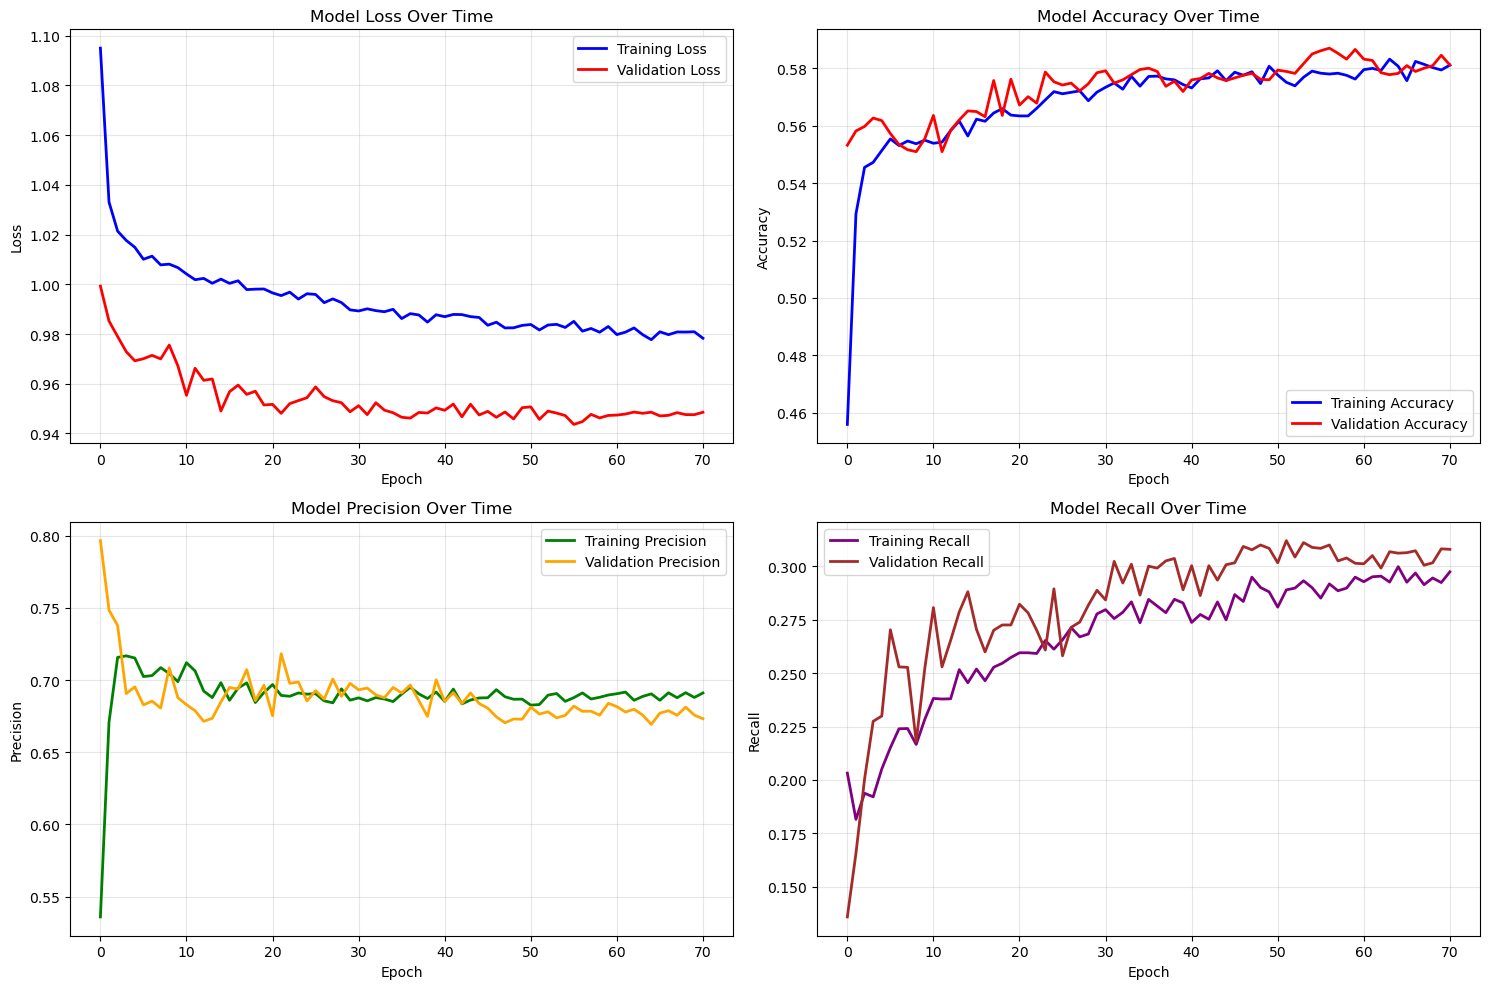


🔍 Training Insights:
   Loss convergence: Good
   Accuracy improvement: 0.028
   Training stability: Stable
   Early stopping activated at epoch 71


In [ ]:
# ================================================================
# Visualize Training History
# ================================================================

# Create comprehensive visualizations of training progress
# Monitor loss, accuracy, and learning curves

print("📊 Creating Training History Visualizations...")

# Create subplots for training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training and Validation Loss
axes[0, 0].plot(train_history['loss'], label='Training Loss', color='blue', linewidth=2)
axes[0, 0].plot(train_history['val_loss'], label='Validation Loss', color='red', linewidth=2)
axes[0, 0].set_title('Model Loss Over Time')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training and Validation Accuracy
axes[0, 1].plot(train_history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
axes[0, 1].plot(train_history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
axes[0, 1].set_title('Model Accuracy Over Time')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Precision
if 'precision' in train_history and 'val_precision' in train_history:
    axes[1, 0].plot(train_history['precision'], label='Training Precision', color='green', linewidth=2)
    axes[1, 0].plot(train_history['val_precision'], label='Validation Precision', color='orange', linewidth=2)
    axes[1, 0].set_title('Model Precision Over Time')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Precision metrics\nnot available', 
                   ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Precision (Not Available)')

# Plot 4: Recall
if 'recall' in train_history and 'val_recall' in train_history:
    axes[1, 1].plot(train_history['recall'], label='Training Recall', color='purple', linewidth=2)
    axes[1, 1].plot(train_history['val_recall'], label='Validation Recall', color='brown', linewidth=2)
    axes[1, 1].set_title('Model Recall Over Time')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Recall metrics\nnot available', 
                   ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Recall (Not Available)')

plt.tight_layout()
plt.show()

# Training insights
print(f"\n🔍 Training Insights:")
print(f"   Loss convergence: {'Good' if train_history['val_loss'][-1] < train_history['val_loss'][0] else 'Poor'}")
print(f"   Accuracy improvement: {train_history['val_accuracy'][-1] - train_history['val_accuracy'][0]:.3f}")
print(f"   Training stability: {'Stable' if len([x for x in train_history['val_loss'][-5:] if x < min(train_history['val_loss'][:-5])]) == 0 else 'Still improving'}")

# Learning rate schedule analysis
if len(history.epoch) < EPOCHS:
    print(f"   Early stopping activated at epoch {len(history.epoch)}")
else:
    print(f"   Completed all {EPOCHS} epochs")

In [ ]:
# ================================================================
# Neural Network Predictions and Evaluation
# ================================================================

# Make predictions and calculate comprehensive performance metrics
# Neural networks provide probability distributions for multi-class problems

print("🔮 Making Neural Network predictions on test set...")
print("=" * 50)

# Generate predictions on test set
print(f"📊 Test set evaluation:")
print(f"   Test samples: {X_test_nn_scaled.shape[0]:,}")

# Get predictions (probabilities and classes)
y_pred_proba_nn = nn_model.predict(X_test_nn_scaled, verbose=0)
y_pred_nn = np.argmax(y_pred_proba_nn, axis=1)

print(f"   Prediction shape: {y_pred_nn.shape}")
print(f"   Probability shape: {y_pred_proba_nn.shape}")

# Calculate comprehensive performance metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

accuracy_nn = accuracy_score(y_test_nn, y_pred_nn)
precision_nn, recall_nn, f1_nn, support_nn = precision_recall_fscore_support(
    y_test_nn, y_pred_nn, average='weighted'
)

print(f"\n🏆 Neural Network Model Performance:")
print(f"   Accuracy: {accuracy_nn:.3f}")
print(f"   Weighted Precision: {precision_nn:.3f}")
print(f"   Weighted Recall: {recall_nn:.3f}")
print(f"   Weighted F1-Score: {f1_nn:.3f}")

# Compare with validation performance
val_test_gap = abs(best_val_accuracy - accuracy_nn)
print(f"\n📈 Validation vs Test Performance:")
print(f"   Best validation accuracy: {best_val_accuracy:.3f}")
print(f"   Test accuracy: {accuracy_nn:.3f}")
print(f"   Validation-Test gap: {val_test_gap:.3f}")
if val_test_gap < 0.02:
    print("   ✅ Excellent generalization")
elif val_test_gap < 0.05:
    print("   ✅ Good generalization")
else:
    print("   ⚠️ Possible overfitting to validation set")

# Detailed classification report
print(f"\n📋 Detailed Neural Network Classification Report:")
class_names = ['Withdrawn', 'Fail', 'Pass']
print(classification_report(y_test_nn, y_pred_nn, target_names=class_names))

# Neural network specific analysis
print(f"\n🧠 Neural Network Prediction Analysis:")
max_probabilities = np.max(y_pred_proba_nn, axis=1)
print(f"   Average prediction confidence: {np.mean(max_probabilities):.3f}")
print(f"   Confidence std dev: {np.std(max_probabilities):.3f}")
print(f"   Min confidence: {np.min(max_probabilities):.3f}")
print(f"   Max confidence: {np.max(max_probabilities):.3f}")

# Confidence distribution analysis
confidence_bins = np.histogram(max_probabilities, bins=[0, 0.4, 0.6, 0.8, 1.0])[0]
confidence_labels = ['Low (0-0.4)', 'Medium (0.4-0.6)', 'High (0.6-0.8)', 'Very High (0.8-1.0)']

print(f"\n🎯 Prediction Confidence Distribution:")
for label, count in zip(confidence_labels, confidence_bins):
    percentage = count / len(max_probabilities) * 100
    print(f"   {label}: {count} predictions ({percentage:.1f}%)")

# High confidence prediction accuracy
high_conf_mask = max_probabilities > 0.8
if np.sum(high_conf_mask) > 0:
    high_conf_accuracy = accuracy_score(y_test_nn[high_conf_mask], y_pred_nn[high_conf_mask])
    print(f"\n   High confidence accuracy (>0.8): {high_conf_accuracy:.3f}")
    print(f"   High confidence samples: {np.sum(high_conf_mask)} ({np.sum(high_conf_mask)/len(y_test_nn)*100:.1f}%)")

# Class-wise probability analysis
print(f"\n📊 Class-wise Prediction Probabilities:")
for class_idx, class_name in enumerate(class_names):
    class_mask = y_test_nn == class_idx
    if np.sum(class_mask) > 0:
        class_probs = y_pred_proba_nn[class_mask, class_idx]
        avg_prob = np.mean(class_probs)
        print(f"   {class_name}: Average probability {avg_prob:.3f} (correctly classified)")


🔮 Making Neural Network predictions on test set...
📊 Test set evaluation:
   Test samples: 5,545
   Prediction shape: (5545,)
   Probability shape: (5545, 3)

🏆 Neural Network Model Performance:
   Accuracy: 0.568
   Weighted Precision: 0.562
   Weighted Recall: 0.568
   Weighted F1-Score: 0.561

📈 Validation vs Test Performance:
   Best validation accuracy: 0.586
   Test accuracy: 0.568
   Validation-Test gap: 0.018
   ✅ Excellent generalization

📋 Detailed Neural Network Classification Report:
              precision    recall  f1-score   support

   Withdrawn       0.37      0.25      0.30      1096
        Fail       0.39      0.47      0.43      1410
        Pass       0.71      0.73      0.72      3039

    accuracy                           0.57      5545
   macro avg       0.49      0.48      0.48      5545
weighted avg       0.56      0.57      0.56      5545


🧠 Neural Network Prediction Analysis:
   Average prediction confidence: 0.506
   Confidence std dev: 0.110
   Min con

📊 Creating Neural Network Confusion Matrix...


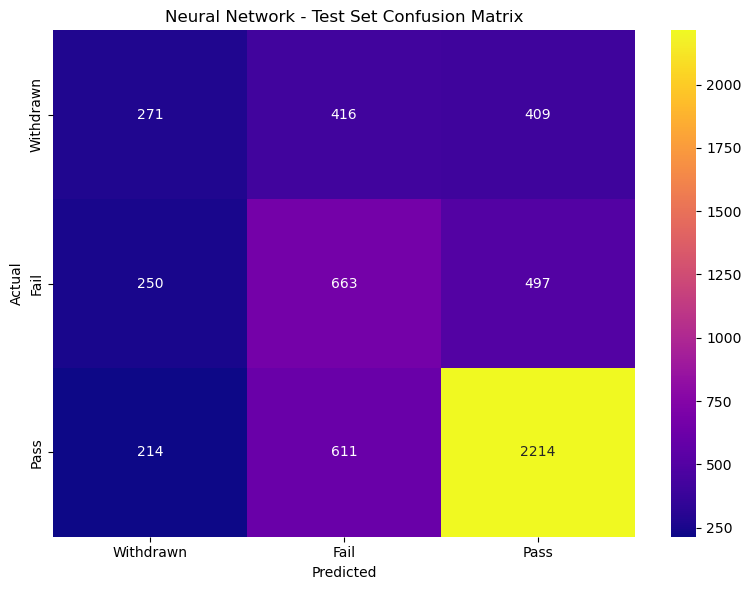


🔍 Neural Network Confusion Matrix Analysis:

Withdrawn (Actual Class 0):
   Predicted as Withdrawn: 271 (24.7%)
   Predicted as Fail: 416 (38.0%)
   Predicted as Pass: 409 (37.3%)

Fail (Actual Class 1):
   Predicted as Withdrawn: 250 (17.7%)
   Predicted as Fail: 663 (47.0%)
   Predicted as Pass: 497 (35.2%)

Pass (Actual Class 2):
   Predicted as Withdrawn: 214 (7.0%)
   Predicted as Fail: 611 (20.1%)
   Predicted as Pass: 2214 (72.9%)

📈 Neural Network Per-Class Accuracy:
   Withdrawn: 0.247
   Fail: 0.470
   Pass: 0.729

❌ Neural Network Error Analysis:
   Total errors: 2397
   Error rate: 43.2%
   Most frequent error: Pass → Fail (611 cases)

🤔 Prediction Uncertainty Analysis:
   Average confidence on errors: 0.473
   Average confidence on correct: 0.531
   Confidence difference: 0.057
   Uncertain errors (<0.6 confidence): 2198/2397 (91.7%)

⚖️ Class Prediction Bias:
   Withdrawn: Actual 1096, Predicted 735, Bias -361 (-32.9%)
   Fail: Actual 1410, Predicted 1690, Bias +280 (+19

In [ ]:
# ================================================================
# Neural Network Confusion Matrix and Error Analysis
# ================================================================

# Create detailed confusion matrix and analyze neural network prediction patterns
# Understand where the model makes mistakes and why

print("📊 Creating Neural Network Confusion Matrix...")

from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm_nn = confusion_matrix(y_test_nn, y_pred_nn)

# Create visualization with neural network color scheme
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='plasma', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Neural Network - Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Detailed confusion matrix analysis
print(f"\n🔍 Neural Network Confusion Matrix Analysis:")
cm_percent_nn = cm_nn.astype('float') / cm_nn.sum(axis=1)[:, np.newaxis] * 100

for i, class_name in enumerate(class_names):
    print(f"\n{class_name} (Actual Class {i}):")
    for j, pred_class in enumerate(class_names):
        count = cm_nn[i, j]
        percent = cm_percent_nn[i, j]
        print(f"   Predicted as {pred_class}: {count} ({percent:.1f}%)")

# Per-class accuracy
print(f"\n📈 Neural Network Per-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_accuracy = cm_nn[i, i] / cm_nn[i, :].sum()
    print(f"   {class_name}: {class_accuracy:.3f}")

# Error pattern analysis
print(f"\n❌ Neural Network Error Analysis:")
total_errors = np.sum(cm_nn) - np.trace(cm_nn)
print(f"   Total errors: {total_errors}")
print(f"   Error rate: {total_errors/len(y_test_nn)*100:.1f}%")

# Find most common errors
max_error = 0
max_error_desc = ""
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm_nn[i, j] > max_error:
            max_error = cm_nn[i, j]
            max_error_desc = f"{class_names[i]} → {class_names[j]}"

print(f"   Most frequent error: {max_error_desc} ({max_error} cases)")

# Analyze prediction uncertainty for errors
print(f"\n🤔 Prediction Uncertainty Analysis:")
error_mask = y_test_nn != y_pred_nn
if np.sum(error_mask) > 0:
    error_confidences = max_probabilities[error_mask]
    correct_confidences = max_probabilities[~error_mask]
    
    print(f"   Average confidence on errors: {np.mean(error_confidences):.3f}")
    print(f"   Average confidence on correct: {np.mean(correct_confidences):.3f}")
    print(f"   Confidence difference: {np.mean(correct_confidences) - np.mean(error_confidences):.3f}")
    
    # Low confidence errors (model is uncertain)
    uncertain_errors = np.sum(error_confidences < 0.6)
    print(f"   Uncertain errors (<0.6 confidence): {uncertain_errors}/{len(error_confidences)} ({uncertain_errors/len(error_confidences)*100:.1f}%)")

# Class prediction bias analysis
print(f"\n⚖️ Class Prediction Bias:")
for class_idx, class_name in enumerate(class_names):
    actual_count = np.sum(y_test_nn == class_idx)
    predicted_count = np.sum(y_pred_nn == class_idx)
    bias = predicted_count - actual_count
    bias_percentage = bias / actual_count * 100 if actual_count > 0 else 0
    
    print(f"   {class_name}: Actual {actual_count}, Predicted {predicted_count}, Bias {bias:+d} ({bias_percentage:+.1f}%)")


In [ ]:
# ================================================================
# Seven-Model Comparison with Neural Networks
# ================================================================

# Ultimate comparison of all individual models plus neural networks
# Compare all 7 individual models plus neural network (excluding ensemble)

print("🏆 SEVEN-MODEL ULTIMATE COMPARISON")
print("=" * 110)

# Performance comparison table with neural network (excluding ensemble)
print(f"📊 Performance Comparison (Test Set):")
print(f"{'Metric':<20} {'Random Forest':<13} {'Logistic Reg':<13} {'Naive Bayes':<13} {'SVM':<13} {'XGBoost':<13} {'LightGBM':<13} {'Neural Net':<13}")
print("-" * 115)
print(f"{'Accuracy':<20} {accuracy:.3f}         {accuracy_lr:.3f}         {accuracy_nb:.3f}         {accuracy_svm:.3f}         {accuracy_xgb:.3f}         {accuracy_lgb:.3f}         {accuracy_nn:.3f}")
print(f"{'Weighted F1':<20} {f1:.3f}         {f1_lr:.3f}         {f1_nb:.3f}         {f1_svm:.3f}         {f1_xgb:.3f}         {f1_lgb:.3f}         {f1_nn:.3f}")
print(f"{'Weighted Precision':<20} {precision:.3f}         {precision_lr:.3f}         {precision_nb:.3f}         {precision_svm:.3f}         {precision_xgb:.3f}         {precision_lgb:.3f}         {precision_nn:.3f}")
print(f"{'Weighted Recall':<20} {recall:.3f}         {recall_lr:.3f}         {recall_nb:.3f}         {recall_svm:.3f}         {recall_xgb:.3f}         {recall_lgb:.3f}         {recall_nn:.3f}")

# Class-wise Recall Comparison with Neural Network (excluding ensemble)
print(f"\n🎯 Class-wise Recall Comparison:")
print(f"{'Class':<15} {'RF':<8} {'LR':<8} {'NB':<8} {'SVM':<8} {'XGB':<8} {'LGB':<8} {'NN':<8} {'Best':<8}")
print("-" * 80)

# Calculate recall for neural network
from sklearn.metrics import recall_score
recall_nn_per_class = recall_score(y_test_nn, y_pred_nn, average=None)

# Display class-wise comparison including neural network (excluding ensemble)
for i, class_name in enumerate(class_names):
    rf_recall = recall_rf_per_class[i]
    lr_recall = recall_lr_per_class[i]
    nb_recall = recall_nb_per_class[i]
    svm_recall = recall_svm_per_class[i]
    xgb_recall = recall_xgb_per_class[i]
    lgb_recall = recall_lgb_per_class[i]
    nn_recall = recall_nn_per_class[i]
    
    # Find best performing model for this class (individual models only)
    class_recalls = {
        'RF': rf_recall, 'LR': lr_recall, 'NB': nb_recall, 'SVM': svm_recall,
        'XGB': xgb_recall, 'LGB': lgb_recall, 'NN': nn_recall
    }
    best_model_class = max(class_recalls, key=class_recalls.get)
    
    print(f"{class_name:<15} {rf_recall:.3f}    {lr_recall:.3f}    {nb_recall:.3f}    {svm_recall:.3f}    {xgb_recall:.3f}    {lgb_recall:.3f}    {nn_recall:.3f}    {best_model_class}")

# Best Performance Summary with Neural Network (excluding ensemble)
print(f"\n🏆 Best Performance:")

# Update performance dictionaries to include neural network (exclude ensemble)
individual_models_accuracy = {
    'Random Forest': accuracy, 'Logistic Regression': accuracy_lr,
    'Naive Bayes': accuracy_nb, 'SVM': accuracy_svm,
    'XGBoost': accuracy_xgb, 'LightGBM': accuracy_lgb,
    'Neural Network': accuracy_nn
}

individual_models_f1 = {
    'Random Forest': f1, 'Logistic Regression': f1_lr,
    'Naive Bayes': f1_nb, 'SVM': f1_svm,
    'XGBoost': f1_xgb, 'LightGBM': f1_lgb,
    'Neural Network': f1_nn
}

# Find best performers among individual models only
best_accuracy_model = max(individual_models_accuracy, key=individual_models_accuracy.get)
best_accuracy_score = individual_models_accuracy[best_accuracy_model]

best_f1_model = max(individual_models_f1, key=individual_models_f1.get)
best_f1_score = individual_models_f1[best_f1_model]

print(f"   Highest Accuracy: {best_accuracy_model} ({best_accuracy_score:.3f})")
print(f"   Highest F1-Score: {best_f1_model} ({best_f1_score:.3f})")

# Model characteristics comparison (individual models only)
print(f"\n🔧 Model Characteristics:")
print(f"{'Aspect':<25} {'Random Forest':<15} {'Logistic Reg':<15} {'Naive Bayes':<15} {'SVM':<15} {'XGBoost':<15} {'LightGBM':<15} {'Neural Net':<15}")
print("-" * 125)
print(f"{'Algorithm Type':<25} {'Ensemble':<15} {'Linear':<15} {'Probabilistic':<15} {'Kernel-based':<15} {'Boosting':<15} {'Boosting':<15} {'Deep Learning':<15}")
print(f"{'Handles Non-linearity':<25} {'Yes':<15} {'No':<15} {'Limited':<15} {'Yes (RBF)':<15} {'Yes':<15} {'Yes':<15} {'Yes':<15}")
print(f"{'Feature Scaling Needed':<25} {'No':<15} {'Yes':<15} {'No':<15} {'Yes':<15} {'No':<15} {'No':<15} {'Yes':<15}")
print(f"{'Interpretability':<25} {'Medium':<15} {'High':<15} {'High':<15} {'Low':<15} {'Medium':<15} {'Medium':<15} {'Low':<15}")
print(f"{'Training Speed':<25} {'Fast':<15} {'Fast':<15} {'Very Fast':<15} {'Slow':<15} {'Medium':<15} {'Very Fast':<15} {'Slow':<15}")
print(f"{'Memory Usage':<25} {'Medium':<15} {'Low':<15} {'Low':<15} {'Medium':<15} {'Medium':<15} {'Low':<15} {'High':<15}")
print(f"{'Overfitting Resistance':<25} {'High':<15} {'Medium':<15} {'High':<15} {'High':<15} {'High':<15} {'High':<15} {'Medium':<15}")

# Final performance ranking (individual models only)
print(f"\n📈 Final Performance Ranking (by Accuracy):")
sorted_individual_models = sorted(individual_models_accuracy.items(), key=lambda x: x[1], reverse=True)
for rank, (model, score) in enumerate(sorted_individual_models, 1):
    improvement_indicator = "🧠" if model == "Neural Network" else ""
    print(f"   {rank}. {model}: {score:.3f} {improvement_indicator}")

# Neural network specific insights
nn_rank = next(i for i, (model, _) in enumerate(sorted_individual_models, 1) if model == "Neural Network")
print(f"\n🧠 Neural Network Performance Analysis:")
print(f"   Neural Network rank: #{nn_rank} out of 7 individual models")
print(f"   Training epochs: {epochs_trained}")
print(f"   Model complexity: {total_params:,} parameters")
print(f"   Generalization: {'Excellent' if val_test_gap < 0.02 else 'Good' if val_test_gap < 0.05 else 'Fair'}")

# Compare neural network with best traditional model
best_traditional_models = ['Random Forest', 'XGBoost', 'LightGBM']
best_traditional_score = max([individual_models_accuracy[model] for model in best_traditional_models])
nn_vs_traditional = accuracy_nn - best_traditional_score

print(f"\n🆚 Neural Network vs Traditional Models:")
print(f"   Best traditional model accuracy: {best_traditional_score:.3f}")
print(f"   Neural Network accuracy: {accuracy_nn:.3f}")
print(f"   Performance difference: {nn_vs_traditional:+.3f}")
if nn_vs_traditional > 0.01:
    print(f"   🎊 Neural Network outperforms traditional models!")
elif nn_vs_traditional > -0.01:
    print(f"   📊 Neural Network competitive with traditional models")
else:
    print(f"   📈 Traditional models perform better")

print(f"\n💡 Individual Model Recommendations:")
print(f"   • For highest accuracy: {best_accuracy_model}")
print(f"   • For complex pattern recognition: Neural Network or XGBoost")
print(f"   • For interpretability: Logistic Regression or Naive Bayes")
print(f"   • For production deployment: {best_accuracy_model}")
print(f"   • For speed: LightGBM or Naive Bayes")
print(f"   • For large datasets: Neural Network or LightGBM")
print(f"   • For feature learning: Neural Network (automatic feature engineering)")
print(f"   • For small datasets: Random Forest or Naive Bayes")

print(f"\n✅ Seven-model individual comparison completed!")
print(f"   Neural Network: {epochs_trained} epochs, {total_params:,} parameters")
print(f"   Best individual performer: {best_accuracy_model}")
print(f"   All models evaluated on {len(y_test_nn):,} test samples")
print(f"   Comparison excludes ensemble methods for fair individual model assessment")

🏆 SEVEN-MODEL ULTIMATE COMPARISON
📊 Performance Comparison (Test Set):
Metric               Random Forest Logistic Reg  Naive Bayes   SVM           XGBoost       LightGBM      Neural Net   
-------------------------------------------------------------------------------------------------------------------
Accuracy             0.575         0.565         0.570         0.259         0.616         0.572         0.568
Weighted F1          0.568         0.561         0.545         0.160         0.563         0.570         0.561
Weighted Precision   0.563         0.558         0.538         0.128         0.577         0.569         0.562
Weighted Recall      0.575         0.565         0.570         0.259         0.616         0.572         0.568

🎯 Class-wise Recall Comparison:
Class           RF       LR       NB       SVM      XGB      LGB      NN       Best    
--------------------------------------------------------------------------------
Withdrawn       0.307    0.366    0.145    0.342